In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os 
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
cd ../data

/Users/marijansoric/Documents/GitHub/Solar-Energy-Production-Forecasting/data


# Plan

1. Delete feature:
- high correlated value
- delete low importance feature with PCA ?
2. Feature Engineering:
- Create new features (time related, Fourier ?)
- Feature = stationary + seasonality + noise
3. Missing Value:
- mean or KNN-Imputation
4. Data transformation:
- Feature: One-hot-encoding for idx and more
- Feature: Apply transformation Box Cox, (log, ^2, 1/,...)
- Y: Apply transformation too!
- Feature: Normalize (MinMax, StandardScaler, Robust)
- X_Estimated: Apply shift between estimated and observed
5. ImBalance Data (too much zero to forecast)
- Build 2 models, one binary classification, and another one for y>0 prediction
6. Training-set:
- Separate in three sets (time is increasing)
- Train only on the spring ?


# Data Import : 

Data import

In [3]:
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
train_a = pd.read_parquet('A/train_targets.parquet')

X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')

X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

Set new index, and delete the old one.

In [4]:
X_train_estimated_a.set_index('date_forecast', inplace = True)
X_train_observed_a.set_index('date_forecast', inplace = True)
X_test_estimated_a.set_index('date_forecast', inplace = True)

X_train_estimated_b.set_index('date_forecast', inplace = True)
X_train_observed_b.set_index('date_forecast', inplace = True)
X_test_estimated_b.set_index('date_forecast', inplace = True)

X_train_estimated_c.set_index('date_forecast', inplace = True)
X_train_observed_c.set_index('date_forecast', inplace = True)
X_test_estimated_c.set_index('date_forecast', inplace = True)


X_train_estimated_a.drop('date_calc', axis=1, inplace=True)
X_test_estimated_a.drop('date_calc', axis=1, inplace=True)

X_train_estimated_b.drop('date_calc', axis=1, inplace=True)
X_test_estimated_b.drop('date_calc', axis=1, inplace=True)

X_train_estimated_c.drop('date_calc', axis=1, inplace=True)
X_test_estimated_c.drop('date_calc', axis=1, inplace=True)


train_a.set_index('time', inplace = True)
train_b.set_index('time', inplace = True)
train_c.set_index('time', inplace = True)

train_a.dropna(inplace = True)
train_b.dropna(inplace = True)
train_c.dropna(inplace = True)

In [5]:
X_test_estimated_c.shape,X_train_observed_c.shape

((2880, 45), (116825, 45))

Match the size of X and Y. We create X_train_estimated_S_matched, X_train_observed_S_matched, train_S_estimated_matched, train_S_observed_matched

In [6]:
X_train_estimated_a = X_train_estimated_a.loc[X_train_estimated_a.index[::4]]
X_train_observed_a = X_train_observed_a.loc[X_train_observed_a.index[::4]]
X_test_estimated_a = X_test_estimated_a.loc[X_test_estimated_a.index[::4]]


X_train_estimated_b = X_train_estimated_b.loc[X_train_estimated_b.index[::4]]
X_train_observed_b = X_train_observed_b.loc[X_train_observed_b.index[::4]]
X_test_estimated_b = X_test_estimated_b.loc[X_test_estimated_b.index[::4]]

X_train_estimated_c = X_train_estimated_c.loc[X_train_estimated_c.index[::4]]
X_train_observed_c = X_train_observed_c.loc[X_train_observed_c.index[::4]]
X_test_estimated_c = X_test_estimated_c.loc[X_test_estimated_c.index[::4]]

intersection_index_estimated_a = X_train_estimated_a.index.intersection(train_a.index)
intersection_index_estimated_b = X_train_estimated_b.index.intersection(train_b.index)
intersection_index_estimated_c = X_train_estimated_c.index.intersection(train_c.index)

intersection_index_observed_a = X_train_observed_a.index.intersection(train_a.index)
intersection_index_observed_b = X_train_observed_b.index.intersection(train_b.index)
intersection_index_observed_c = X_train_observed_c.index.intersection(train_c.index)


X_train_estimated_a = X_train_estimated_a.loc[intersection_index_estimated_a]
X_train_estimated_b = X_train_estimated_b.loc[intersection_index_estimated_b]
X_train_estimated_c = X_train_estimated_c.loc[intersection_index_estimated_c]


X_train_observed_a = X_train_observed_a.loc[intersection_index_observed_a]
X_train_observed_b = X_train_observed_b.loc[intersection_index_observed_b]
X_train_observed_c = X_train_observed_c.loc[intersection_index_observed_c]


train_a_estimated = train_a.loc[intersection_index_estimated_a]
train_b_estimated = train_b.loc[intersection_index_estimated_b]
train_c_estimated = train_c.loc[intersection_index_estimated_c]

train_a_observed = train_a.loc[intersection_index_observed_a]
train_b_observed = train_b.loc[intersection_index_observed_b]
train_c_observed = train_c.loc[intersection_index_observed_c]

In [7]:
#We match the sizes of X and Y 
#We keep the measurements from every hour only 
intersection_index_estimated_a = X_train_estimated_a.index.intersection(train_a.index)
intersection_index_estimated_b = X_train_estimated_b.index.intersection(train_b.index)
intersection_index_estimated_c = X_train_estimated_c.index.intersection(train_c.index)

intersection_index_observed_a = X_train_observed_a.index.intersection(train_a.index)
intersection_index_observed_b = X_train_observed_b.index.intersection(train_b.index)
intersection_index_observed_c = X_train_observed_c.index.intersection(train_c.index)


X_train_estimated_a = X_train_estimated_a.loc[intersection_index_estimated_a]
X_train_estimated_b = X_train_estimated_b.loc[intersection_index_estimated_b]
X_train_estimated_c = X_train_estimated_c.loc[intersection_index_estimated_c]


X_train_observed_a = X_train_observed_a.loc[intersection_index_observed_a]
X_train_observed_b = X_train_observed_b.loc[intersection_index_observed_b]
X_train_observed_c = X_train_observed_c.loc[intersection_index_observed_c]


train_a_estimated = train_a.loc[intersection_index_estimated_a]
train_b_estimated = train_b.loc[intersection_index_estimated_b]
train_c_estimated = train_c.loc[intersection_index_estimated_c]

train_a_observed = train_a.loc[intersection_index_observed_a]
train_b_observed = train_b.loc[intersection_index_observed_b]
train_c_observed = train_c.loc[intersection_index_observed_c]

In [8]:
important = ['direct_rad:W^2',
 'rad:W',
 'rad_T:WK',
 'direct_rad:W',
 'sun_azimuth:d',
 'Year cos',
 'msl_pressure:hPa',
 'ceiling_height_agl:m',
 'absolute_humidity_2m:gm3',
 'cloud_base_agl:m',
 'wind_speed_u_10m:ms',
 'visibility:m',
 'Year sin',
 't_1000hPa:K',
 'total_cloud_cover:p',
 'wind_speed_v_10m:ms',
 'clear_sky_rad:W',
 'relative_humidity_1000hPa:p',
 'diffuse_rad_1h:J',
 'diffuse_rad:W',
 'sun_elevation:d',
 'clear_sky_rad:W^2']

In [9]:
X['direct_rad:W^2'] = X['direct_rad:W'].apply(lambda x: x**2)
X['clear_sky_rad:W^2'] = X['clear_sky_rad:W'].apply(lambda x: x**2)

NameError: name 'X' is not defined

In [ ]:
X['rad:W'] = X[['direct_rad:W', 'diffuse_rad:W']].apply(lambda x: x[0]+x[1], axis=1)
X['rad_T:WK'] = X[['t_1000hPa:K', 'rad:W']].apply(lambda x: x[0]*x[1], axis=1)
X['ration_rad:W'] = X[['direct_rad:W', 'diffuse_rad:W']].apply(lambda x: x[0]/(x[0]+x[1]) if x[0]+x[1] !=0 else 0, axis=1)

In [ ]:
i=3
plt.scatter(X[important[i]], y, s=.1)

In [10]:
X = pd.concat([X_train_observed_a, X_train_estimated_a], axis = 0)

In [89]:
y = pd.concat([train_a_observed, train_a_estimated], axis = 0)

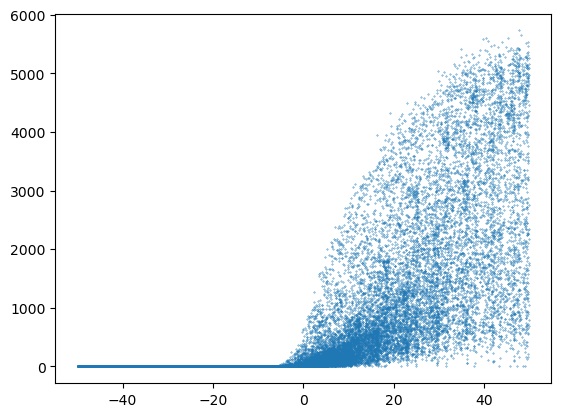

In [14]:
x = X_train_observed_a['sun_elevation:d']
y = train_a_observed.loc[x.index]

plt.scatter(x, y, s=.1)

In [14]:
X['ceiling_height_agl:m'].isna().count()

34061

In [15]:
threshold_sun_elevation = [-10, -10, -5]

In [16]:
train_a_observed[train_a_observed==0].count()/len(train_a_observed)*100

pv_measurement    44.895001
dtype: float64

In [17]:
X_train_observed_a[X_train_observed_a['sun_elevation:d']< -10]['sun_elevation:d'].count()/len(X_train_observed_a)*100

30.980550780328308

In [18]:
X_train_estimated_a[X_train_estimated_a['sun_elevation:d']< -10]['sun_elevation:d'].count()/len(X_train_estimated_a)*100

50.0

In [19]:
X_test_estimated_a[X_test_estimated_a['sun_elevation:d']< -10]['sun_elevation:d'].count()/len(X_test_estimated_a)*100

0.5555555555555556

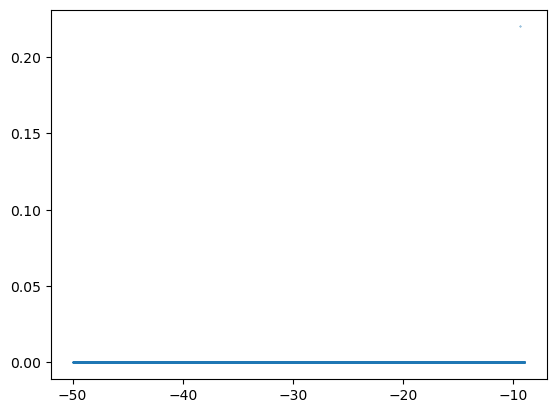

In [20]:
x = X_train_observed_a[X_train_observed_a['sun_elevation:d']< -9]['sun_elevation:d']
y=train_a_observed.loc[x.index]

plt.scatter(x, y, s=.1)

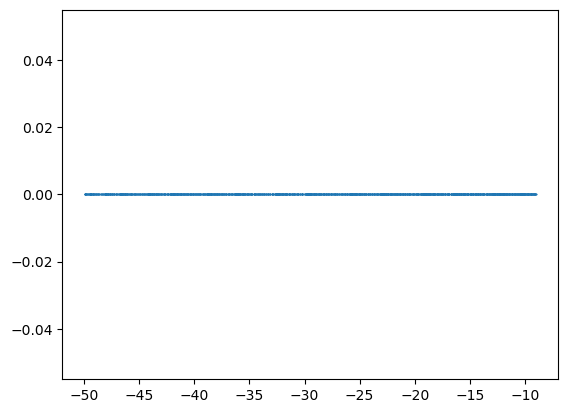

In [21]:
x = X_train_estimated_a[X_train_estimated_a['sun_elevation:d']< -9]['sun_elevation:d']
y=train_a_estimated.loc[x.index]

plt.scatter(x, y, s=.1)

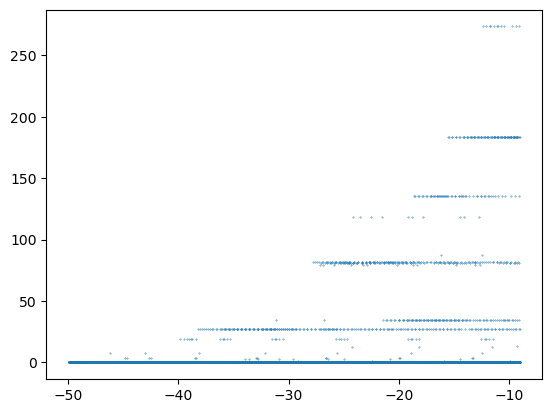

In [22]:
x = X_train_observed_b[X_train_observed_b['sun_elevation:d']< -9]['sun_elevation:d']
y=train_b_observed.loc[x.index]

plt.scatter(x, y, s=.1)

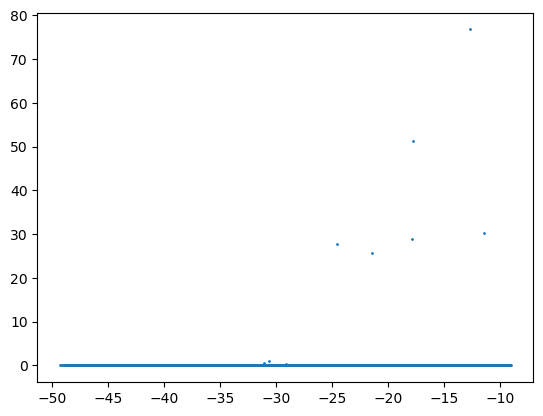

In [23]:
x = X_train_estimated_b[X_train_estimated_b['sun_elevation:d']< -9]['sun_elevation:d']
y=train_b_estimated.loc[x.index]

plt.scatter(x, y, s=1)

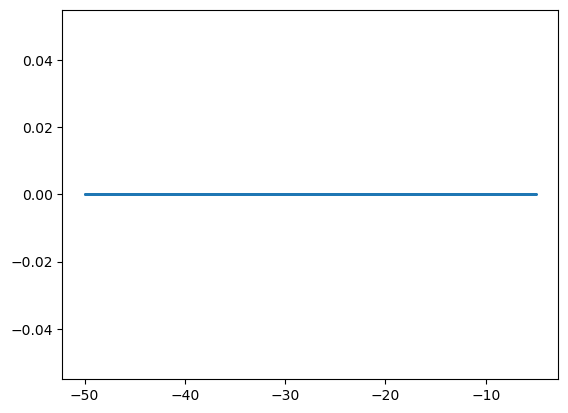

In [24]:
x = X_train_observed_c[X_train_observed_c['sun_elevation:d']< -5]['sun_elevation:d']
y=train_c_observed.loc[x.index]

plt.scatter(x, y, s=.1)

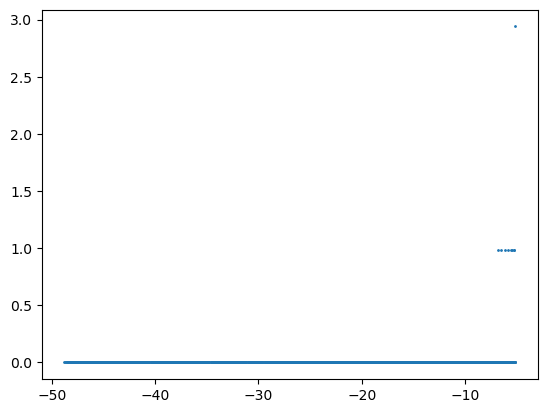

In [25]:
x = X_train_estimated_c[X_train_estimated_c['sun_elevation:d']< -5]['sun_elevation:d']
y=train_c_estimated.loc[x.index]

plt.scatter(x, y, s=1)

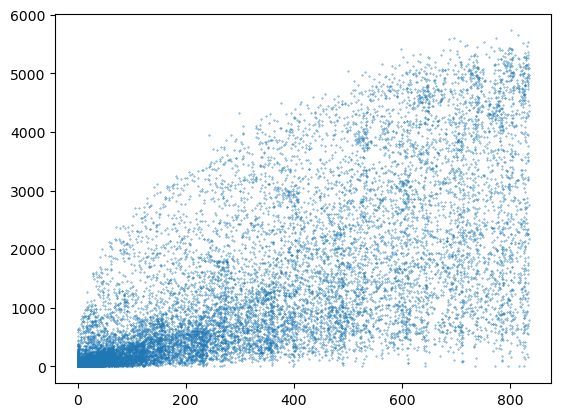

In [26]:
plt.scatter(X_train_observed_a['clear_sky_rad:W'],train_a_observed, s=.1)

<Axes: xlabel='clear_sky_rad:W', ylabel='Count'>

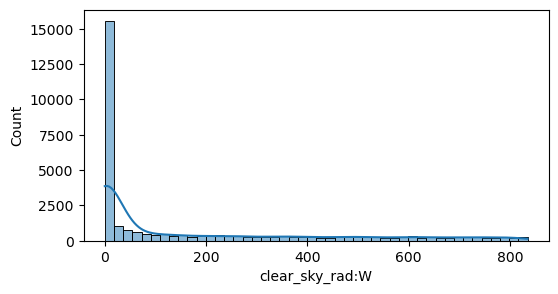

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))

sns.histplot(data=X_train_observed_a['clear_sky_rad:W'], kde=True)
#sns.histplot(data=train_a_observed, kde=True)


In [28]:
X_test_estimated_c.shape,X_train_observed_c.shape

((720, 45), (23141, 45))

# 1. Delete feature:
- high correlated value
- constant values
- delete low importance feature with PCA ?

## high correlated value

In [29]:
corr_matrix = X_train_observed_a.corr().abs()
high_corr_var=np.where(corr_matrix>0.95)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('absolute_humidity_2m:gm3', 'dew_point_2m:K'),
 ('clear_sky_energy_1h:J', 'clear_sky_rad:W'),
 ('diffuse_rad:W', 'diffuse_rad_1h:J'),
 ('direct_rad:W', 'direct_rad_1h:J'),
 ('msl_pressure:hPa', 'pressure_100m:hPa'),
 ('msl_pressure:hPa', 'pressure_50m:hPa'),
 ('msl_pressure:hPa', 'sfc_pressure:hPa'),
 ('pressure_100m:hPa', 'pressure_50m:hPa'),
 ('pressure_100m:hPa', 'sfc_pressure:hPa'),
 ('pressure_50m:hPa', 'sfc_pressure:hPa')]

In [30]:
to_drop = ['absolute_humidity_2m:gm3', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 
           'direct_rad_1h:J', 'total_cloud_cover:p', 
           'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa',
          'cloud_base_agl:m'] ## too much NAN 
         # 'rain_water:kgm2'

In [31]:
#Delete features because high correlation between them (>0.9) : 
X_train_estimated_a.drop(to_drop, axis=1, inplace=True)
X_train_estimated_b.drop(to_drop, axis=1, inplace=True)
X_train_estimated_c.drop(to_drop, axis=1, inplace=True)

X_train_observed_a.drop(to_drop, axis=1, inplace=True)
X_train_observed_b.drop(to_drop, axis=1, inplace=True)
X_train_observed_c.drop(to_drop, axis=1, inplace=True)
    
X_test_estimated_a.drop(to_drop, axis=1, inplace=True)
X_test_estimated_b.drop(to_drop, axis=1, inplace=True)
X_test_estimated_c.drop(to_drop, axis=1, inplace=True)

In [32]:
X_train_estimated_a.shape[1]

36

## constant values

Drop features that are constant for each station.

In [33]:
X_train_estimated_a.columns

Index(['air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_rad:W',
       'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W', 'direct_rad:W',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms',
       'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms'],
      dtype='object')

In [34]:
constant_values_a = ['snow_drift:idx', 'snow_density:kgm3', 'elevation:m']
constant_values_b = ['snow_density:kgm3', 'elevation:m']
constant_values_c = ['snow_density:kgm3', 'elevation:m']

In [35]:
#Delete because constant values:
X_train_estimated_a.drop(constant_values_a, axis=1, inplace=True)
X_train_observed_a.drop(constant_values_a, axis=1, inplace=True)
X_test_estimated_a.drop(constant_values_a, axis=1, inplace=True)

X_train_estimated_b.drop(constant_values_b, axis=1, inplace=True)
X_train_observed_b.drop(constant_values_b, axis=1, inplace=True)
X_test_estimated_b.drop(constant_values_b, axis=1, inplace=True)
    
X_train_estimated_c.drop(constant_values_c, axis=1, inplace=True)
X_train_observed_c.drop(constant_values_c, axis=1, inplace=True)
X_test_estimated_c.drop(constant_values_c, axis=1, inplace=True)

## delete low importance feature with PCA ?

We can also delete more features...

In [36]:
# and more
#to_drop = ['feature_name']

Attempt with PCA

# 2. Feature Engineering:
- Create new features (time related, Fourier ?)
- Feature = stationary + seasonality + noise

In [37]:
X_test_estimated_c.shape,X_train_observed_c.shape

((720, 34), (23141, 34))

Add y for each day (according to the y mean) for a whole year. 

## Time related features (year and day)

In [38]:
#We change the Time that is a string, to a variable in seconds 
timestamp_s_observed_a = X_train_observed_a.index.map(pd.Timestamp.timestamp)
timestamp_s_observed_b = X_train_observed_b.index.map(pd.Timestamp.timestamp)
timestamp_s_observed_c = X_train_observed_c.index.map(pd.Timestamp.timestamp)

timestamp_s_estimated_a = X_train_estimated_a.index.map(pd.Timestamp.timestamp)
timestamp_s_estimated_b = X_train_estimated_b.index.map(pd.Timestamp.timestamp)
timestamp_s_estimated_c = X_train_estimated_c.index.map(pd.Timestamp.timestamp)

timestamp_s_test_a = X_test_estimated_a.index.map(pd.Timestamp.timestamp)
timestamp_s_test_b = X_test_estimated_b.index.map(pd.Timestamp.timestamp)
timestamp_s_test_c = X_test_estimated_c.index.map(pd.Timestamp.timestamp)

#Then, we incorporate the periodicity
day = 24*60*60
year = (365.2425)*day

X_train_observed_a['Day sin'] = np.sin(timestamp_s_observed_a * (2 * np.pi / day))
X_train_observed_a['Day cos'] = np.cos(timestamp_s_observed_a * (2 * np.pi / day))
X_train_observed_a['Year sin'] = np.sin(timestamp_s_observed_a * (2 * np.pi / year))
X_train_observed_a['Year cos'] = np.cos(timestamp_s_observed_a * (2 * np.pi / year))

X_train_observed_b['Day sin'] = np.sin(timestamp_s_observed_b * (2 * np.pi / day))
X_train_observed_b['Day cos'] = np.cos(timestamp_s_observed_b * (2 * np.pi / day))
X_train_observed_b['Year sin'] = np.sin(timestamp_s_observed_b * (2 * np.pi / year))
X_train_observed_b['Year cos'] = np.cos(timestamp_s_observed_b * (2 * np.pi / year))

X_train_observed_c['Day sin'] = np.sin(timestamp_s_observed_c * (2 * np.pi / day))
X_train_observed_c['Day cos'] = np.cos(timestamp_s_observed_c * (2 * np.pi / day))
X_train_observed_c['Year sin'] = np.sin(timestamp_s_observed_c * (2 * np.pi / year))
X_train_observed_c['Year cos'] = np.cos(timestamp_s_observed_c * (2 * np.pi / year))


X_train_estimated_a['Day sin'] = np.sin(timestamp_s_estimated_a * (2 * np.pi / day))
X_train_estimated_a['Day cos'] = np.cos(timestamp_s_estimated_a * (2 * np.pi / day))
X_train_estimated_a['Year sin'] = np.sin(timestamp_s_estimated_a * (2 * np.pi / year))
X_train_estimated_a['Year cos'] = np.cos(timestamp_s_estimated_a * (2 * np.pi / year))

X_train_estimated_b['Day sin'] = np.sin(timestamp_s_estimated_b * (2 * np.pi / day))
X_train_estimated_b['Day cos'] = np.cos(timestamp_s_estimated_b * (2 * np.pi / day))
X_train_estimated_b['Year sin'] = np.sin(timestamp_s_estimated_b * (2 * np.pi / year))
X_train_estimated_b['Year cos'] = np.cos(timestamp_s_estimated_b * (2 * np.pi / year))

X_train_estimated_c['Day sin'] = np.sin(timestamp_s_estimated_c * (2 * np.pi / day))
X_train_estimated_c['Day cos'] = np.cos(timestamp_s_estimated_c * (2 * np.pi / day))
X_train_estimated_c['Year sin'] = np.sin(timestamp_s_estimated_c * (2 * np.pi / year))
X_train_estimated_c['Year cos'] = np.cos(timestamp_s_estimated_c * (2 * np.pi / year))


X_test_estimated_a['Day sin'] = np.sin(timestamp_s_test_a * (2 * np.pi / day))
X_test_estimated_a['Day cos'] = np.cos(timestamp_s_test_a * (2 * np.pi / day))
X_test_estimated_a['Year sin'] = np.sin(timestamp_s_test_a * (2 * np.pi / year))
X_test_estimated_a['Year cos'] = np.cos(timestamp_s_test_a * (2 * np.pi / year))

X_test_estimated_b['Day sin'] = np.sin(timestamp_s_test_b * (2 * np.pi / day))
X_test_estimated_b['Day cos'] = np.cos(timestamp_s_test_b * (2 * np.pi / day))
X_test_estimated_b['Year sin'] = np.sin(timestamp_s_test_b * (2 * np.pi / year))
X_test_estimated_b['Year cos'] = np.cos(timestamp_s_test_b * (2 * np.pi / year))

X_test_estimated_c['Day sin'] = np.sin(timestamp_s_test_c * (2 * np.pi / day))
X_test_estimated_c['Day cos'] = np.cos(timestamp_s_test_c * (2 * np.pi / day))
X_test_estimated_c['Year sin'] = np.sin(timestamp_s_test_c * (2 * np.pi / year))
X_test_estimated_c['Year cos'] = np.cos(timestamp_s_test_c * (2 * np.pi / year))


(<Axes: >,)

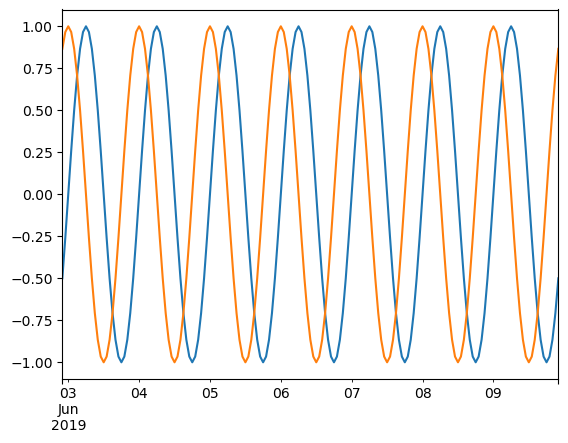

In [39]:
X_train_observed_a['Day sin'].loc['2019-06-02 22:00:00':'2019-06-09 22:00:00'].plot(),
X_train_observed_a['Day cos'].loc['2019-06-02 22:00:00':'2019-06-09 22:00:00'].plot(),

(<Axes: >,)

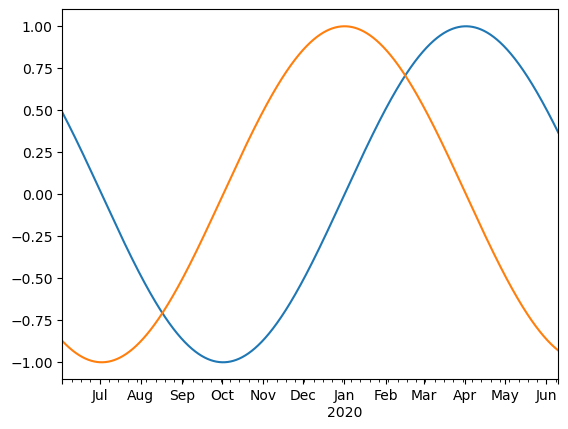

In [40]:
X_train_observed_a['Year sin'].loc['2019-06-02 22:00:00':'2020-06-09 22:00:00'].plot(),
X_train_observed_a['Year cos'].loc['2019-06-02 22:00:00':'2020-06-09 22:00:00'].plot(),

In [23]:
#We change the sun_azimuth variable, because an angle in degree is not really comprehensible for the machine (0 and 360 should be the same)
#therefore, we introduce the sinus and cosinus features
X_train_observed_a['sun_azimuth_cos:'] = np.cos(X_train_observed_a['sun_azimuth:d'])
X_train_observed_a['sun_azimuth_sin:'] = np.sin(X_train_observed_a['sun_azimuth:d'])
X_train_estimated_a['sun_azimuth_cos:'] = np.cos(X_train_estimated_a['sun_azimuth:d'])
X_train_estimated_a['sun_azimuth_sin:'] = np.sin(X_train_estimated_a['sun_azimuth:d'])
X_test_estimated_a['sun_azimuth_cos:'] = np.cos(X_test_estimated_a['sun_azimuth:d'])
X_test_estimated_a['sun_azimuth_sin:'] = np.sin(X_test_estimated_a['sun_azimuth:d'])
X_train_observed_a.drop(['sun_azimuth:d'], axis = 1, inplace = True)
X_train_estimated_a.drop(['sun_azimuth:d'], axis = 1, inplace = True)
X_test_estimated_a.drop(['sun_azimuth:d'], axis = 1, inplace = True)


X_train_observed_b['sun_azimuth_cos:'] = np.cos(X_train_observed_b['sun_azimuth:d'])
X_train_observed_b['sun_azimuth_sin:'] = np.sin(X_train_observed_b['sun_azimuth:d'])
X_train_estimated_b['sun_azimuth_cos:'] = np.cos(X_train_estimated_b['sun_azimuth:d'])
X_train_estimated_b['sun_azimuth_sin:'] = np.sin(X_train_estimated_b['sun_azimuth:d'])
X_test_estimated_b['sun_azimuth_cos:'] = np.cos(X_test_estimated_b['sun_azimuth:d'])
X_test_estimated_b['sun_azimuth_sin:'] = np.sin(X_test_estimated_b['sun_azimuth:d'])
X_train_observed_b.drop(['sun_azimuth:d'], axis = 1, inplace = True)
X_train_estimated_b.drop(['sun_azimuth:d'], axis = 1, inplace = True)
X_test_estimated_b.drop(['sun_azimuth:d'], axis = 1, inplace = True)

X_train_observed_c['sun_azimuth_cos:'] = np.cos(X_train_observed_c['sun_azimuth:d'])
X_train_observed_c['sun_azimuth_sin:'] = np.sin(X_train_observed_c['sun_azimuth:d'])
X_train_estimated_c['sun_azimuth_cos:'] = np.cos(X_train_estimated_c['sun_azimuth:d'])
X_train_estimated_c['sun_azimuth_sin:'] = np.sin(X_train_estimated_c['sun_azimuth:d'])
X_test_estimated_c['sun_azimuth_cos:'] = np.cos(X_test_estimated_c['sun_azimuth:d'])
X_test_estimated_c['sun_azimuth_sin:'] = np.sin(X_test_estimated_c['sun_azimuth:d'])
X_train_observed_c.drop(['sun_azimuth:d'], axis = 1, inplace = True)
X_train_estimated_c.drop(['sun_azimuth:d'], axis = 1, inplace = True)
X_test_estimated_c.drop(['sun_azimuth:d'], axis = 1, inplace = True)

(<Axes: >,)

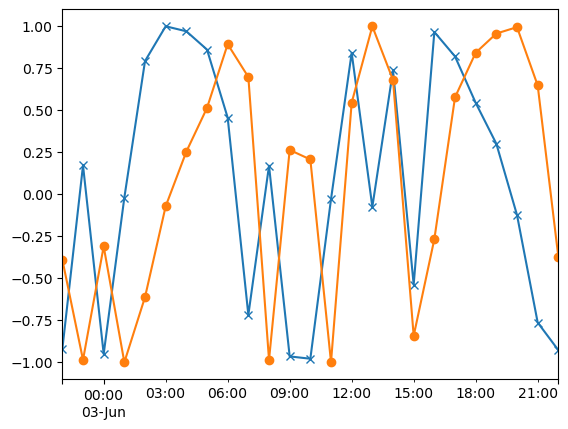

In [24]:
X_train_observed_a['sun_azimuth_cos:'].loc['2019-06-02 22:00:00':'2019-06-03 22:00:00'].plot(marker='x'),
X_train_observed_a['sun_azimuth_sin:'].loc['2019-06-02 22:00:00':'2019-06-03 22:00:00'].plot(marker='o'),

## Average y for each day

In [25]:
X_test_estimated_c.shape[1],X_train_observed_c.shape[1]

(39, 39)

In [26]:
def average_y(y):
    average = []
    for M in [str(m) for m in range(1,13)]:
        for D in [str(d) for d in range(28)]:
            for H in [str(h) for h in range(24)]:
                mean = y.loc[f'2020-{M}-{D} {H}', f'2021-{M}-{D} {H}', f'2022-{M}-{D} {H}'].mean()
                average.append([f'{M}-{D} {H}', mean])
    return average

<Axes: >

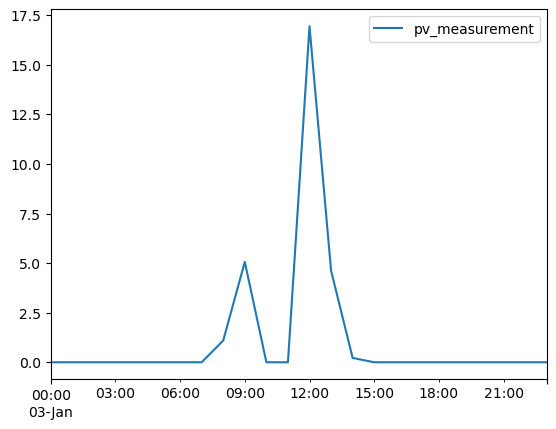

In [27]:
train_a_observed.loc['2020-1-3'].plot()

In [28]:
a='01'
train_a_observed.loc[[f'2020-{a}-01 01','2021-01-01 01','2022-01-01 01']].mean()

pv_measurement    0.0
dtype: float64

# 3. Missing Value:
- mean or KNN-Imputation

For the missing values, we fill with differents methods such as : 0, mean, KNN-Imputer.

## Mean

In [29]:
X_train_estimated_a.isna().mean().sort_values(ascending=False)[:3]*100

ceiling_height_agl:m    25.967228
air_density_2m:kgm3      0.000000
wind_speed_10m:ms        0.000000
dtype: float64

In [30]:
#Missing values
value={'ceiling_height_agl:m' : X_train_estimated_a['ceiling_height_agl:m'].mean(),
      # 'cloud_base_agl:m' : -9999#X_train_estimated_a['cloud_base_agl:m'].mean()
      }

X_train_estimated_a = X_train_estimated_a.fillna(value=value)
X_train_observed_a = X_train_observed_a.fillna(value=value)
X_test_estimated_a = X_test_estimated_a.fillna(value=value)

X_train_estimated_b = X_train_estimated_b.fillna(value=value)
X_train_observed_b = X_train_observed_b.fillna(value=value)
X_test_estimated_b = X_test_estimated_b.fillna(value=value)

X_train_estimated_c = X_train_estimated_c.fillna(value=value)
X_train_observed_c = X_train_observed_c.fillna(value=value)
X_test_estimated_c = X_test_estimated_c.fillna(value=value)

In [31]:
X_train_estimated_a.isna().mean().sort_values(ascending=False)[:3]*100

air_density_2m:kgm3    0.0
wind_speed_10m:ms      0.0
snow_depth:cm          0.0
dtype: float64

## K-NN - Imputer

With KNN-Imputer.

## SHIFT

 X_Estimated: Apply shift between estimated and observed

In [41]:
X_test_estimated_c.shape[1],X_train_observed_c.shape[1]

(38, 38)

(1.2490646, 1.2817329)

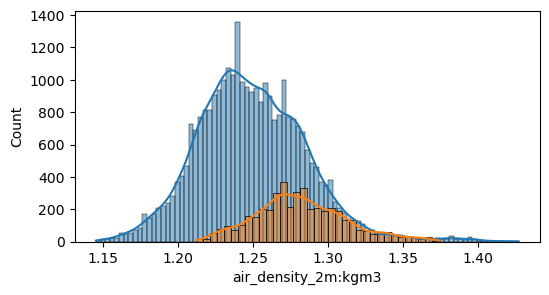

In [43]:
i = 0

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))

#sns.histplot(data=X_train_observed_a_est.loc[A_index21_est].iloc[:,i], kde=True)
sns.histplot(data=X_train_observed_a.iloc[:,i], kde=True)
sns.histplot(data=X_train_estimated_a.iloc[:,i], kde=True)

X_train_observed_a.iloc[:,i].mean(), X_train_estimated_a.iloc[:,i].mean(), 

We create a function SHIFT, in order to have the same expected value and SD between observed and estimate for the same time-period (like spring).

In [44]:
def shift(X_obs, X_est):
    mu_obs, sd_obs = X_obs.mean(), np.sqrt(X_obs.var())
    mu_est, sd_est = X_est.mean(), np.sqrt(X_est.var())
    if sd_est>0:
        X_est = (X_est - mu_est) / sd_est
        X_est = (X_est * sd_obs) + mu_obs
        return X_est
    else:
        return X_est

We select lines from X_observed value for a specific time-period.

### Test Estimated SHIFT Train Observed

In [45]:
X_test_estimated_a.index

DatetimeIndex(['2023-05-01 00:00:00', '2023-05-01 01:00:00',
               '2023-05-01 02:00:00', '2023-05-01 03:00:00',
               '2023-05-01 04:00:00', '2023-05-01 05:00:00',
               '2023-05-01 06:00:00', '2023-05-01 07:00:00',
               '2023-05-01 08:00:00', '2023-05-01 09:00:00',
               ...
               '2023-07-03 14:00:00', '2023-07-03 15:00:00',
               '2023-07-03 16:00:00', '2023-07-03 17:00:00',
               '2023-07-03 18:00:00', '2023-07-03 19:00:00',
               '2023-07-03 20:00:00', '2023-07-03 21:00:00',
               '2023-07-03 22:00:00', '2023-07-03 23:00:00'],
              dtype='datetime64[us]', name='date_forecast', length=720, freq=None)

In [46]:
A_index20 = X_train_observed_a.loc['2020-05-01 00:00:00':'2020-07-03 23:45:00'].index
A_index21 = X_train_observed_a.loc['2021-05-01 00:00:00':'2021-07-03 23:45:00'].index
A_index22 = X_train_observed_a.loc['2022-05-01 00:00:00':'2022-07-03 23:45:00'].index

B_index19 = X_train_observed_b.loc['2019-05-01 00:00:00':'2019-07-03 23:45:00'].index
B_index20 = X_train_observed_b.loc['2020-05-01 00:00:00':'2020-07-03 23:45:00'].index
B_index21 = X_train_observed_b.loc['2021-05-01 00:00:00':'2021-07-03 23:45:00'].index

C_index20 = X_train_observed_c.loc['2020-05-01 00:00:00':'2020-07-03 23:45:00'].index
C_index21 = X_train_observed_c.loc['2021-05-01 00:00:00':'2021-07-03 23:45:00'].index

A_index_spring = A_index20.union(A_index21).union(A_index22)
B_index_spring = B_index19.union(B_index20).union(B_index21)
C_index_spring = C_index20.union(C_index21) 

X_train_observed_a_sping = X_train_observed_a.loc[A_index_spring]
X_train_observed_b_sping = X_train_observed_b.loc[B_index_spring]
X_train_observed_c_sping = X_train_observed_c.loc[C_index_spring]

We update X_test_estimated

In [37]:
for i in range(X_test_estimated_a.shape[1]):
    X_obs, X_est = X_train_observed_a_sping.iloc[:,i], X_test_estimated_a.iloc[:,i]
    X_est_new = shift(X_obs, X_est)
    X_test_estimated_a.iloc[:,i] = X_est_new
    
for i in range(X_test_estimated_b.shape[1]):
    X_obs, X_est = X_train_observed_b_sping.iloc[:,i], X_test_estimated_b.iloc[:,i]
    X_est_new = shift(X_obs, X_est)
    X_test_estimated_b.iloc[:,i] = X_est_new
    
for i in range(X_test_estimated_c.shape[1]):
    X_obs, X_est = X_train_observed_c_sping.iloc[:,i], X_test_estimated_c.iloc[:,i]
    X_est_new = shift(X_obs, X_est)
    X_test_estimated_c.iloc[:,i] = X_est_new

MEAN  X_obs_spring 1.2302513122558594       X_test_shift 1.2331750392913818
VAR X_obs_spring 0.0007503448869101703       X_test_shift 0.0010362036991864443


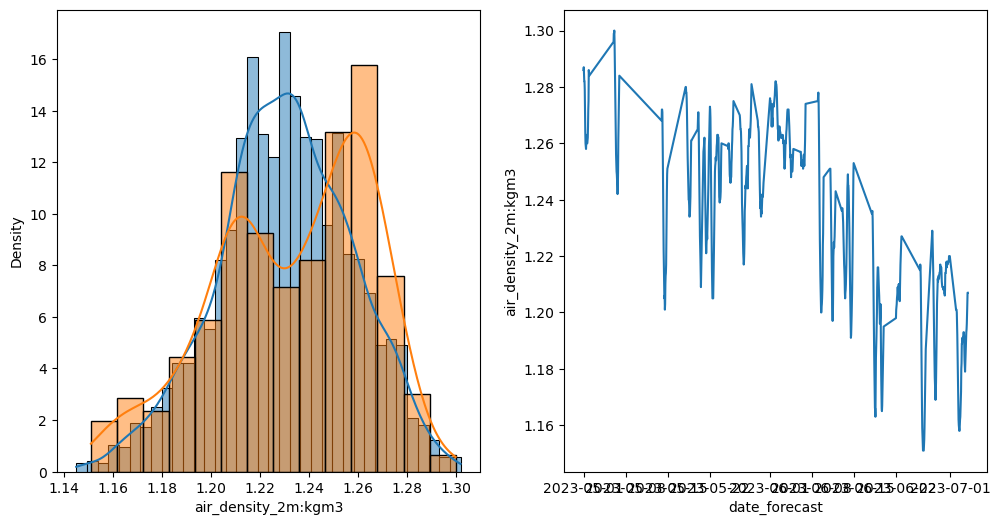

In [62]:
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.histplot(data=X_train_observed_a_sping.iloc[:,i], kde=True, stat="density", ax=axes[0])
sns.histplot(data=X_test_estimated_a.iloc[:,i], kde=True, stat="density", ax=axes[0])

#sns.lineplot(data=X_train_observed_a_sping.iloc[:,i], ax=axes[1])
sns.lineplot(data=X_test_estimated_a.iloc[:,i], ax=axes[1])


print(f'MEAN  X_obs_spring {X_train_observed_a_sping.iloc[:,i].mean()} \
      X_test_shift {X_test_estimated_a.iloc[:,i].mean()}')

print(f'VAR X_obs_spring {X_train_observed_a_sping.iloc[:,i].var()} \
      X_test_shift {X_test_estimated_a.iloc[:,i].var()}')

In [61]:
len(X_test_estimated_a)*3

2160

<Axes: >

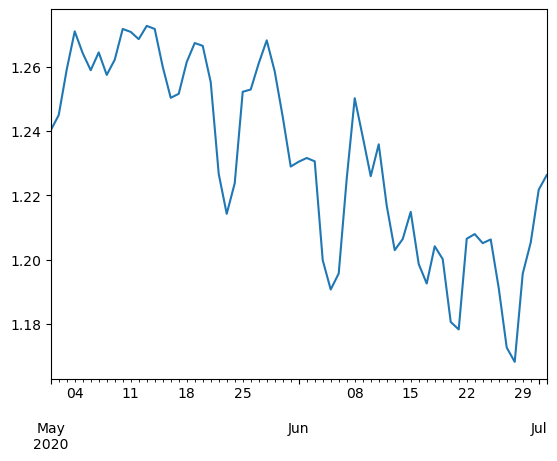

In [71]:
X_train_observed_a_sping.iloc[:1500,i].resample('D').mean().plot()

### Train Estimated SHIFT Train Observed

Same thing for X_train_estimated.

In [39]:
X_train_estimated_a.index

DatetimeIndex(['2022-10-28 22:00:00', '2022-10-28 23:00:00',
               '2022-10-29 00:00:00', '2022-10-29 01:00:00',
               '2022-10-29 02:00:00', '2022-10-29 03:00:00',
               '2022-10-29 04:00:00', '2022-10-29 05:00:00',
               '2022-10-29 06:00:00', '2022-10-29 07:00:00',
               ...
               '2023-04-30 14:00:00', '2023-04-30 15:00:00',
               '2023-04-30 16:00:00', '2023-04-30 17:00:00',
               '2023-04-30 18:00:00', '2023-04-30 19:00:00',
               '2023-04-30 20:00:00', '2023-04-30 21:00:00',
               '2023-04-30 22:00:00', '2023-04-30 23:00:00'],
              dtype='datetime64[us]', length=4394, freq=None)

In [40]:
A_index19_est = X_train_observed_a.loc['2019-10-28 22:00:00':'2020-04-30 23:00:00'].index
A_index20_est = X_train_observed_a.loc['2020-10-28 22:00:00':'2021-04-30 23:00:00'].index
A_index21_est = X_train_observed_a.loc['2021-10-28 22:00:00':'2022-04-30 23:00:00'].index

B_index19_est = X_train_observed_b.loc['2019-10-28 22:00:00':'2020-04-30 23:00:00'].index
B_index20_est = X_train_observed_b.loc['2020-10-28 22:00:00':'2021-04-30 23:00:00'].index
B_index21_est = X_train_observed_b.loc['2021-10-28 22:00:00':'2022-04-30 23:00:00'].index

C_index19_est = X_train_observed_c.loc['2019-10-28 22:00:00':'2020-04-30 23:00:00'].index
C_index20_est = X_train_observed_c.loc['2020-10-28 22:00:00':'2021-04-30 23:00:00'].index
C_index21_est = X_train_observed_c.loc['2021-10-28 22:00:00':'2022-04-30 23:00:00'].index


A_index_est = A_index19_est.union(A_index20_est).union(A_index21_est)
B_index_est = B_index19_est.union(B_index20_est).union(B_index21_est)
C_index_est = C_index19_est.union(C_index20_est).union(C_index21_est)

X_train_observed_a_est = X_train_observed_a.loc[A_index_est]
X_train_observed_b_est = X_train_observed_b.loc[B_index_est]
X_train_observed_c_est = X_train_observed_c.loc[C_index_est]

We update X_train_estimated

In [41]:
for i in range(X_train_estimated_a.shape[1]):
    X_obs, X_est = X_train_observed_a_est.iloc[:,i], X_train_estimated_a.iloc[:,i]
    X_est_new = shift(X_obs, X_est)
    X_train_estimated_a.iloc[:,i] = X_est_new
    
for i in range(X_train_estimated_b.shape[1]):
    X_obs, X_est = X_train_observed_b_est.iloc[:,i], X_train_estimated_b.iloc[:,i]
    X_est_new = shift(X_obs, X_est)
    X_train_estimated_b.iloc[:,i] = X_est_new
    
for i in range(X_train_estimated_c.shape[1]):
    X_obs, X_est = X_train_observed_b_est.iloc[:,i], X_train_estimated_c.iloc[:,i]
    X_est_new = shift(X_obs, X_est)
    X_train_estimated_c.iloc[:,i] = X_est_new

MEAN  X_obs_est 1.2749099731445312       X_train_est_shift 1.2749100923538208
VAR X_obs_est 0.0009565947693772614       X_train_est_shift 0.0009565873187966645


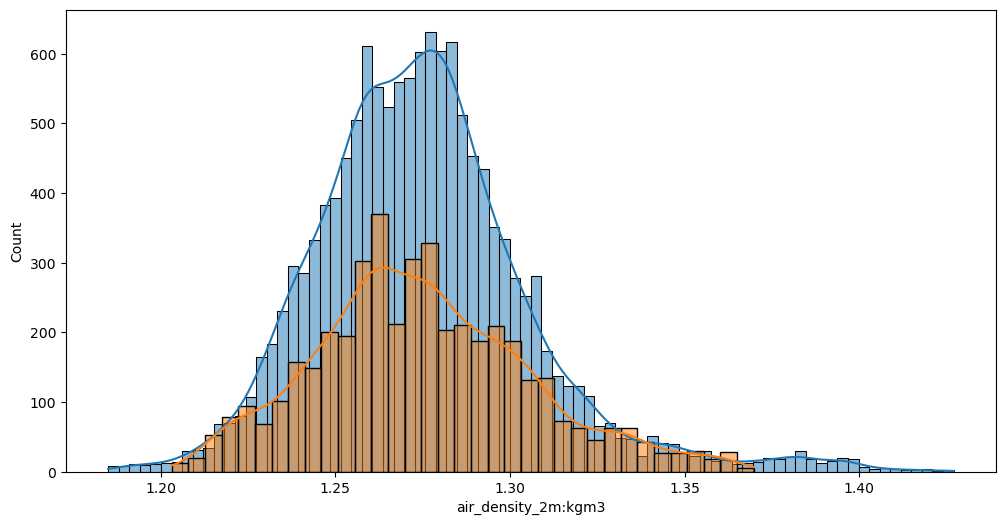

In [42]:
i = 0

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

sns.histplot(data=X_train_observed_a_est.iloc[:,i], kde=True)
sns.histplot(data=X_train_estimated_a.iloc[:,i], kde=True)

print(f'MEAN  X_obs_est {X_train_observed_a_est.iloc[:,i].mean()} \
      X_train_est_shift {X_train_estimated_a.iloc[:,i].mean()}')

print(f'VAR X_obs_est {X_train_observed_a_est.iloc[:,i].var()} \
      X_train_est_shift {X_train_estimated_a.iloc[:,i].var()}')

# 4. Data transformation:
- Feature: One-hot-encoding for idx and more
- Feature: Apply transformation Box Cox, (log, ^2, 1/,...)
- Y: Apply transformation too!
- Feature: Normalize (MinMax, StandardScaler, Robust)
- X_Estimated: Apply shift between estimated and observed

## one-hot-encoding

In [43]:
X_test_estimated_c.shape[1],X_train_observed_c.shape[1]

(39, 39)

We apply _one-hot-encoder_, for categorials features. We saw that 'rain_water:kgm2' is also a categorial feature.

In [44]:
#One Hot encoding 
from sklearn.preprocessing import OneHotEncoder

idx_a = ['dew_or_rime:idx', 'is_in_shadow:idx', 'precip_type_5min:idx']#, 'rain_water:kgm2']
idx_b_c = ['dew_or_rime:idx', 'is_in_shadow:idx', 'precip_type_5min:idx', 'snow_drift:idx']#, 'rain_water:kgm2']


for id in idx_a:
    concatenated_df = pd.concat([X_train_observed_a[id], X_train_estimated_a[id], X_test_estimated_a[id]])
    one_hot_encoded = pd.get_dummies(concatenated_df, prefix= id)
    
    df_estimated_encoded = one_hot_encoded.loc[X_train_estimated_a.index]
    df_observed_encoded = one_hot_encoded.loc[X_train_observed_a.index]
    df_test_encoded = one_hot_encoded.loc[X_test_estimated_a.index]
    
    X_train_observed_a = pd.concat([X_train_observed_a, df_observed_encoded], axis =1)
    X_train_estimated_a = pd.concat([X_train_estimated_a, df_estimated_encoded], axis = 1)
    X_test_estimated_a = pd.concat([X_test_estimated_a, df_test_encoded], axis = 1)
    
    X_train_observed_a.drop([id], inplace = True, axis=1)
    X_train_estimated_a.drop([id], inplace = True, axis=1)
    X_test_estimated_a.drop([id], inplace = True, axis=1)
    
for id in idx_b_c:
    concatenated_df = pd.concat([X_train_observed_b[id], X_train_estimated_b[id], X_test_estimated_b[id]])
    one_hot_encoded = pd.get_dummies(concatenated_df, prefix= id)
    
    df_estimated_encoded = one_hot_encoded.loc[X_train_estimated_b.index]
    df_observed_encoded = one_hot_encoded.loc[X_train_observed_b.index]
    df_test_encoded = one_hot_encoded.loc[X_test_estimated_b.index]
    
    X_train_observed_b = pd.concat([X_train_observed_b, df_observed_encoded], axis =1)
    X_train_estimated_b = pd.concat([X_train_estimated_b, df_estimated_encoded], axis = 1)
    X_test_estimated_b = pd.concat([X_test_estimated_b, df_test_encoded], axis = 1)
    
    X_train_observed_b.drop([id], inplace = True, axis=1)
    X_train_estimated_b.drop([id], inplace = True, axis=1)
    X_test_estimated_b.drop([id], inplace = True, axis=1)
    
for id in idx_b_c:
    concatenated_df = pd.concat([X_train_observed_c[id], X_train_estimated_c[id], X_test_estimated_c[id]])
    one_hot_encoded = pd.get_dummies(concatenated_df, prefix= id)
    
    df_estimated_encoded = one_hot_encoded.loc[X_train_estimated_c.index]
    df_observed_encoded = one_hot_encoded.loc[X_train_observed_c.index]
    df_test_encoded = one_hot_encoded.loc[X_test_estimated_c.index]
    
    X_train_observed_c = pd.concat([X_train_observed_c, df_observed_encoded], axis =1)
    X_train_estimated_c = pd.concat([X_train_estimated_c, df_estimated_encoded], axis = 1)
    X_test_estimated_c = pd.concat([X_test_estimated_c, df_test_encoded], axis = 1)
    
    X_train_observed_c.drop([id], inplace = True, axis=1)
    X_train_estimated_c.drop([id], inplace = True, axis=1)
    X_test_estimated_c.drop([id], inplace = True, axis=1)

In [45]:
X_train_observed_a.iloc[:,34:].head()

,sun_azimuth_sin:,dew_or_rime:idx_-1.0,dew_or_rime:idx_-0.8139334917068481,dew_or_rime:idx_-0.009455524384975433,dew_or_rime:idx_-0.005352207459509373,dew_or_rime:idx_0.0,dew_or_rime:idx_0.7441135048866272,dew_or_rime:idx_0.803229033946991,dew_or_rime:idx_1.0,is_in_shadow:idx_-0.0007054805755615234,is_in_shadow:idx_0.0,is_in_shadow:idx_0.010412052273750305,is_in_shadow:idx_0.9996842741966248,is_in_shadow:idx_1.0,is_in_shadow:idx_1.0341228246688843,precip_type_5min:idx_0.0,precip_type_5min:idx_0.0012713447213172913,precip_type_5min:idx_0.01858188956975937,precip_type_5min:idx_1.0,precip_type_5min:idx_1.1464533805847168,precip_type_5min:idx_1.226620078086853,precip_type_5min:idx_2.0,precip_type_5min:idx_2.4346585273742676,precip_type_5min:idx_3.0,precip_type_5min:idx_3.6426963806152344,precip_type_5min:idx_5.0,precip_type_5min:idx_6.0
2019-06-02 22:00:00,-0.389801,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
2019-06-02 23:00:00,-0.985375,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
2019-06-03 00:00:00,-0.310978,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
2019-06-03 01:00:00,-0.999781,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
2019-06-03 02:00:00,-0.612414,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


## Apply transformation Box Cox, (log, ^2, 1/,...)
- Y: Apply transformation too!

## Regressor

In [46]:
X_test_estimated_c.shape[1],X_train_observed_c.shape[1]

(65, 65)

### Transformation for regression (y>0 + spring)

In [47]:
def normalize(feature):
    return (feature - feature.min())/(feature.max()-feature.min())

We have to create new dataframe for the regressor that are:
- During spring
- Having $y>0$

In [48]:
X_train_estimated_a_reg = X_train_estimated_a.copy()
X_train_observed_a_reg = X_train_observed_a.copy()
X_test_estimated_a_reg = X_test_estimated_a.copy()

X_train_estimated_b_reg = X_train_estimated_b.copy()
X_train_observed_b_reg = X_train_observed_b.copy()
X_test_estimated_b_reg = X_test_estimated_b.copy()

X_train_estimated_c_reg = X_train_estimated_c.copy()
X_train_observed_c_reg = X_train_observed_c.copy()
X_test_estimated_c_reg = X_test_estimated_c.copy()

In [49]:
X_test_estimated_c_reg.shape[1]

65

In [50]:
X_train_observed_a_reg = X_train_observed_a_reg.loc[A_index_spring]
X_train_observed_b_reg = X_train_observed_b_reg.loc[B_index_spring]
X_train_observed_c_reg = X_train_observed_c_reg.loc[C_index_spring]

X_train_observed_a_reg = X_train_observed_a_reg.loc[train_a_observed[train_a_observed.pv_measurement >0].index.intersection(X_train_observed_a_reg.index)]
X_train_observed_b_reg = X_train_observed_b_reg.loc[train_b_observed[train_b_observed.pv_measurement >0].index.intersection(X_train_observed_b_reg.index)]
X_train_observed_c_reg = X_train_observed_c_reg.loc[train_c_observed[train_c_observed.pv_measurement >0].index.intersection(X_train_observed_c_reg.index)]

In [51]:
y_a_reg = train_a_observed[train_a_observed.pv_measurement >0]
y_a_reg = y_a_reg.loc[A_index_spring.intersection(y_a_reg.index)]

y_b_reg = train_b_observed[train_b_observed.pv_measurement >0]
y_b_reg = y_b_reg.loc[B_index_spring.intersection(y_b_reg.index)]

y_c_reg = train_c_observed[train_c_observed.pv_measurement >0]
y_c_reg = y_c_reg.loc[C_index_spring.intersection(y_c_reg.index)]

In [52]:
X_new = X_train_observed_a_reg

mean 49.332672 36.269913 79.31312 5.9635906 84.62515 86.72791
var f:1193.279541015625, f2:1195.124755859375, logf:656.5629272460938, f_1:464.287841796875, logfc:516.3570556640625, loglogf:514.0241088867188


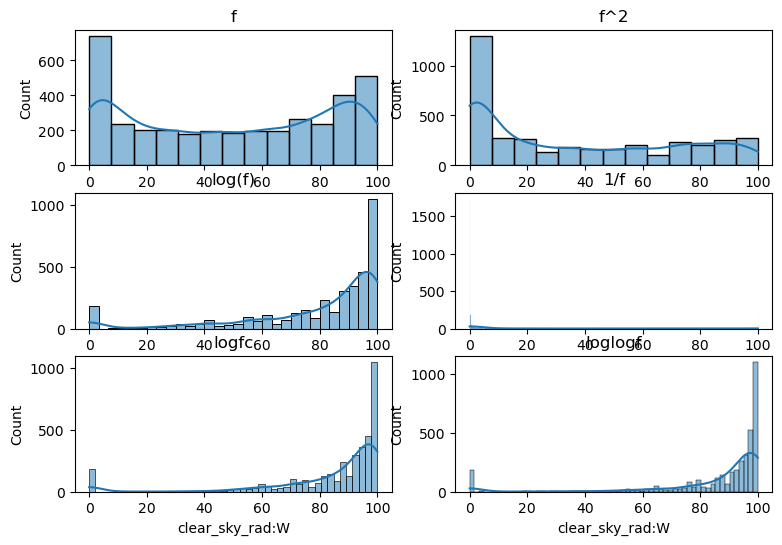

In [53]:
i = 2
token = True

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 6))
axes = axes.flatten()
feature = X_new.iloc[:,i]#.resample('M').mean()

f = normalize(feature)*100
sns.histplot(data=f, ax=axes[0], kde=True)
axes[0].set_title("f")

f2 = normalize((feature)**2)*100
sns.histplot(data=f2, ax=axes[1], kde=True)
axes[1].set_title("f^2")

logf = normalize(np.log(feature+1))*100
sns.histplot(data=logf, ax=axes[2], kde=True)
axes[2].set_title("log(f)")

if token:
    f_1 = normalize(1/(feature+1))*100
    sns.histplot(data=f_1, ax=axes[3], kde=True)
    axes[3].set_title("1/f")


c = (feature.quantile(.25)/feature.quantile(.75))**2
logfc = normalize(np.log(feature+c))*100
sns.histplot(data=logfc, ax=axes[4], kde=True)
axes[4].set_title("logfc")

loglogf = normalize(np.log(np.log(feature+1)+1))*100
sns.histplot(data=loglogf, ax=axes[5], kde=True)
axes[5].set_title("loglogf")


print('mean',f.mean(),np.mean(f2), np.mean(logf), np.mean(f_1), np.mean(logfc), np.mean(loglogf))
print(f'var f:{np.var(f)}, f2:{np.var(f2)}, logf:{np.var(logf)}, f_1:{np.var(f_1)}, logfc:{np.var(logfc)}, loglogf:{np.var(loglogf)}')

In [54]:
X_test_estimated_c.shape[1],X_train_observed_c.shape[1]

(65, 65)

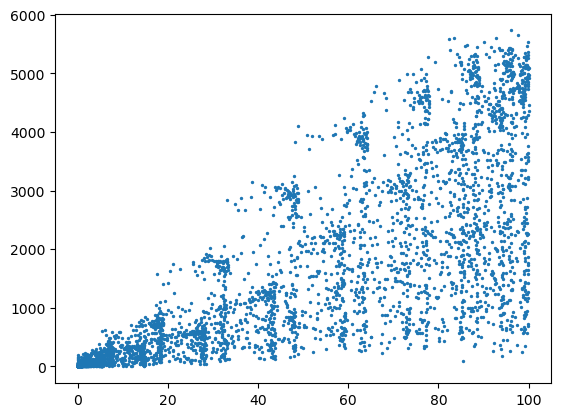

In [55]:
plt.scatter(f, y_a_reg,s=2)

In [56]:
transformations_reg = [['absolute_humidity_2m:gm3', 'logf'],
 ['air_density_2m:kgm3', 'f'],
 ['ceiling_height_agl:m', 'f'],
 ['clear_sky_rad:W', 'f'],
 ['cloud_base_agl:m', 'logf'],
 ['dew_point_2m:K', 'f'],
 ['dew_or_rime:idx', 'hot'],
 ['diffuse_rad:W','logf'],
 ['diffuse_rad_1h:J','f'],
 ['direct_rad:W','logf'],
 ['effective_cloud_cover:p', 'f ou rien'], #??
 ['msl_pressure:hPa','f'],
 ['pressure_100m:hPa', 'loglogf'],
 ['pressure_50m:hPa', 'f'],
 ['relative_humidity_1000hPa:p', 'f^2'],
 ['sun_azimuth:d', 'f'],
 ['sun_elevation:d', 'f'],
 ['super_cooled_liquid_water:kgm2', 'ECODING'],
 ['t_1000hPa:K', 'f^2'],
 ['total_cloud_cover:p', 'f^2 ou rien'], #???
 ['visibility:m', 'f'],
 ['wind_speed_10m:ms', 'logf'],
 ['wind_speed_u_10m:ms', 'f'],
 ['wind_speed_v_10m:ms', 'f'],
 ['wind_speed_w_1000hPa:ms', 'hot']]

Apply transformation only for the regression X! 

In [57]:
for X in [X_train_estimated_a_reg, X_train_observed_a_reg, X_test_estimated_a_reg,
         X_train_estimated_b_reg, X_train_observed_b_reg, X_test_estimated_b_reg,
         X_train_estimated_c_reg, X_train_observed_c_reg, X_test_estimated_c_reg]: 
    for feature, function in transformations_reg:
        if feature in X_train_estimated_a_reg.columns:
            if function == '1/f':
                X[feature] = 1/(X[feature]+1)
            if function == 'logfc':
                X[feature] = np.log(X[feature] + (X[feature].quantile(.25)/X[feature].quantile(.75))**2 )
            if function == 'f^2':
                X[feature] = (X[feature])**2
            if function == 'logf':
                X[feature] = np.log(X[feature]+1)
            if function == 'loglogf':
                X[feature] = np.log(np.log(X[feature]+1)+1)

/Users/marijansoric/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([[<Axes: title={'center': 'air_density_2m:kgm3'}>,
        <Axes: title={'center': 'ceiling_height_agl:m'}>,
        <Axes: title={'center': 'clear_sky_rad:W'}>,
        <Axes: title={'center': 'dew_point_2m:K'}>,
        <Axes: title={'center': 'diffuse_rad:W'}>,
        <Axes: title={'center': 'direct_rad:W'}>],
       [<Axes: title={'center': 'effective_cloud_cover:p'}>,
        <Axes: title={'center': 'fresh_snow_12h:cm'}>,
        <Axes: title={'center': 'fresh_snow_1h:cm'}>,
        <Axes: title={'center': 'fresh_snow_24h:cm'}>,
        <Axes: title={'center': 'fresh_snow_3h:cm'}>,
        <Axes: title={'center': 'fresh_snow_6h:cm'}>],
       [<Axes: title={'center': 'is_day:idx'}>,
        <Axes: title={'center': 'msl_pressure:hPa'}>,
        <Axes: title={'center': 'precip_5min:mm'}>,
        <Axes: title={'center': 'prob_rime:p'}>,
        <Axes: title={'center': 'rain_water:kgm2'}>,
        <Axes: title={'center': 'relative_humidity_1000hPa:p'}>],
       [<Axes: title={

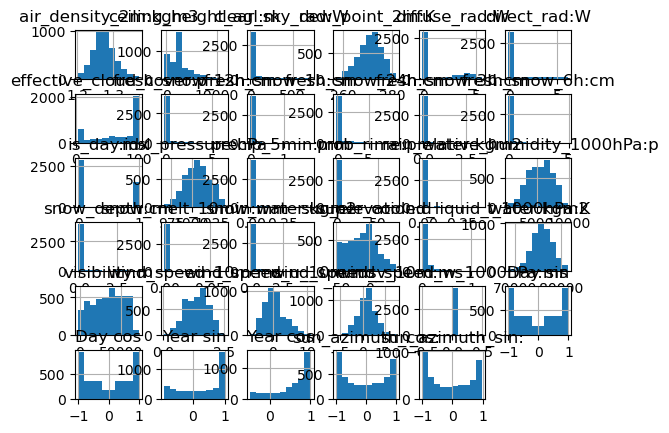

In [58]:
X_train_estimated_a_reg.iloc[:,:].hist()

In [59]:
X_test_estimated_c.shape[1],X_train_observed_c.shape[1]

(65, 65)

### Transformation on y for regression

Transformation on y

In [60]:
y_new = y_a_reg

Text(0.5, 1.0, 'histo log y')

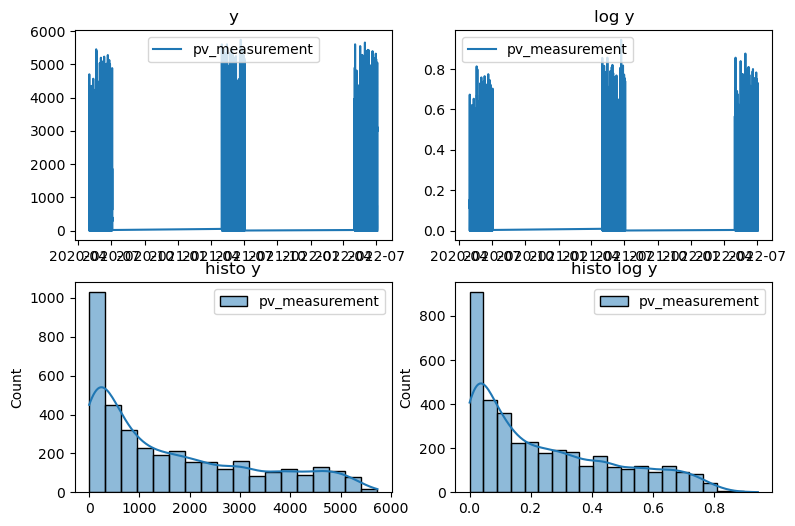

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))
axes = axes.flatten()

d1 = (y_new)
d2 = np.log(1+np.arcsin(y_new/y_new.max()))#np.log(y_new + 1)

sns.lineplot(data=d1, ax=axes[0])
axes[0].set_title("y")

sns.lineplot(data=d2, ax=axes[1])
axes[1].set_title("log y")



sns.histplot(data=d1, ax=axes[2], kde=True)
axes[2].set_title("histo y")

sns.histplot(data=d2, ax=axes[3], kde=True)
axes[3].set_title("histo log y")


<Axes: >

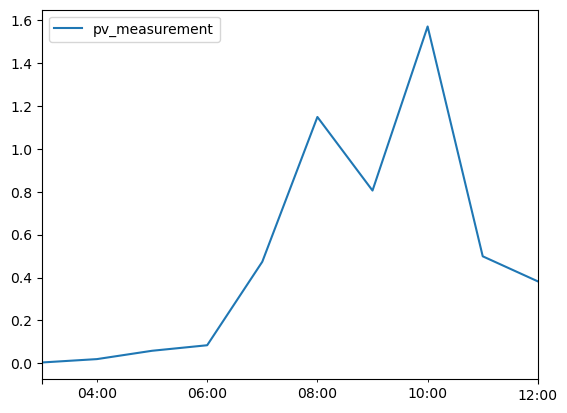

In [62]:
np.arcsin(y_new[:10]/y_new[:10].max()).plot()

<Axes: ylabel='Count'>

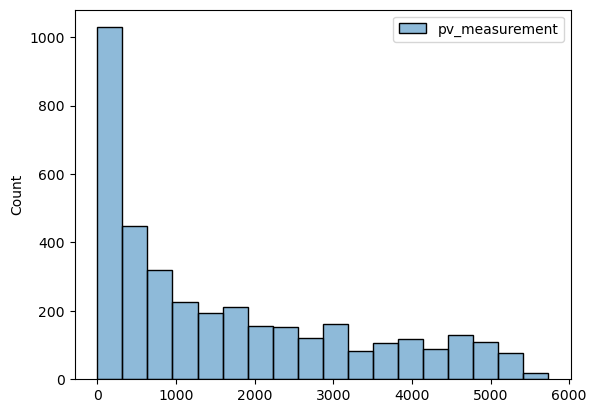

In [63]:
sns.histplot(y_new[:])

<Axes: ylabel='Count'>

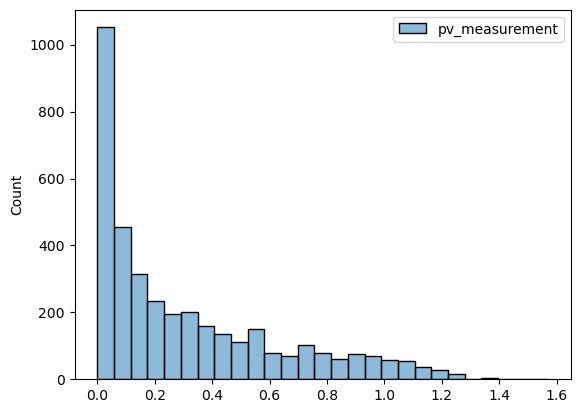

In [64]:
sns.histplot((np.arcsin(y_new[:]/y_new[:].max())))

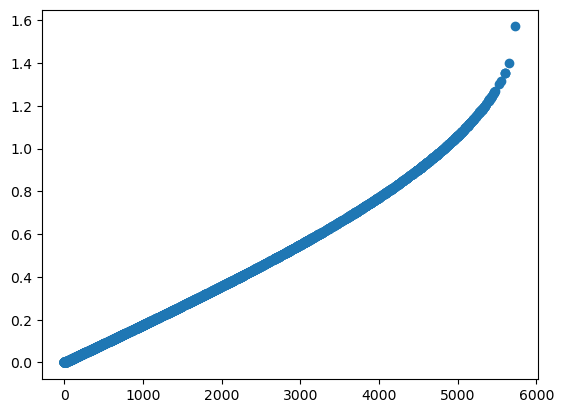

In [65]:
plt.scatter(y_new[:], np.arcsin(y_new[:]/y_new[:].max()))

(<Axes: >, <Axes: >, <Axes: >)

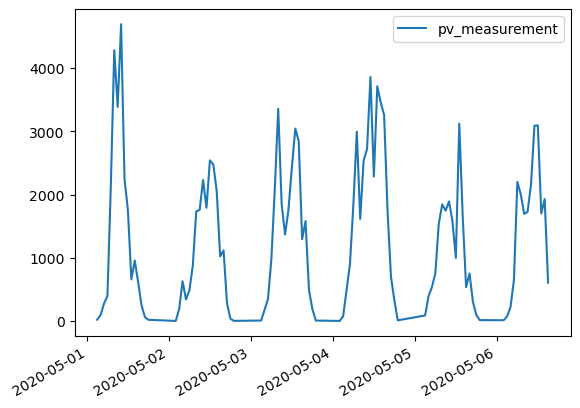

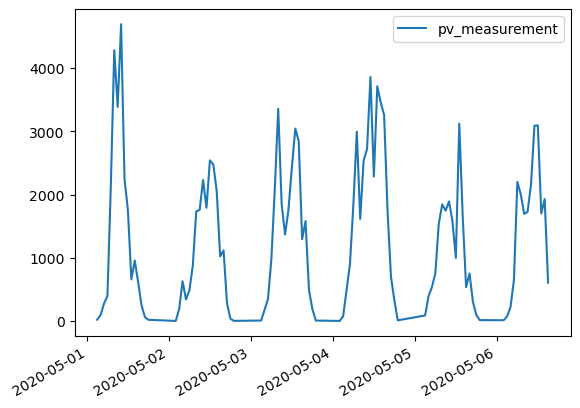

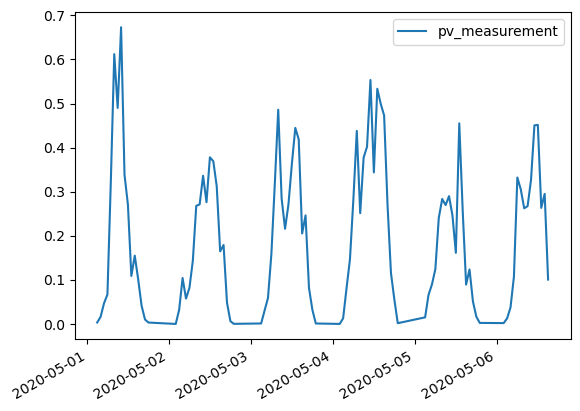

In [66]:
y_new[:100].plot(),d1[:100].plot(),d2[:100].plot()


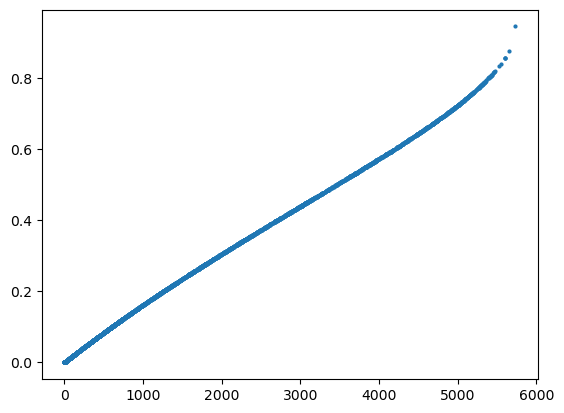

In [67]:
plt.scatter(d1[:],d2[:], s=4)

Idea: do not predict y but rather $sin(x)$ and $cos(x)$.

Normalize the $y$ ?

## Classifier

### Transformation for classification (X_obs and X_test)

In [68]:
def normalize(feature):
    return (feature - feature.min())/(feature.max()-feature.min())

In [69]:
X_new = X_train_observed_a

mean 23.552275 8.976768 70.8938 2.6252902 71.02295 77.97707
var f:336.3717956542969, f2:203.2539520263672, logf:228.83314514160156, f_1:92.96829223632812, logfc:227.4806365966797, loglogf:182.91595458984375


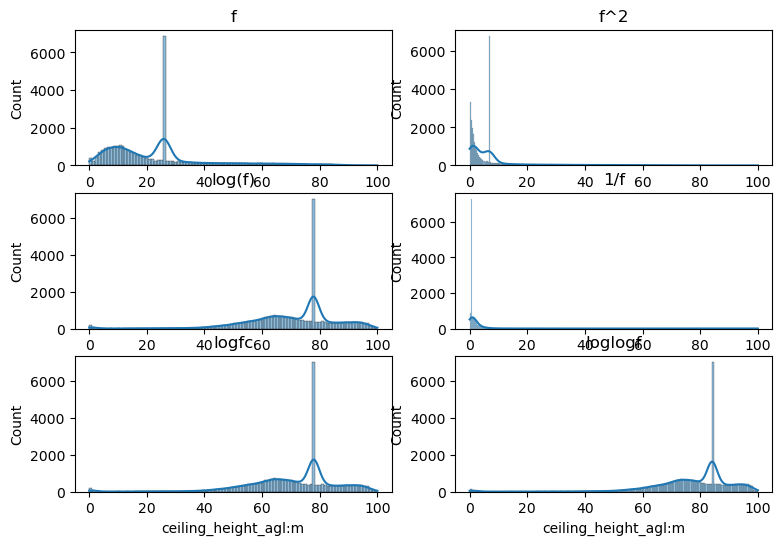

In [70]:
i = 1
token = True

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 6))
axes = axes.flatten()
feature = X_new.iloc[:,i]#.resample('M').mean()

f = normalize(feature)*100
sns.histplot(data=f, ax=axes[0], kde=True)
axes[0].set_title("f")

f2 = normalize((feature)**2)*100
sns.histplot(data=f2, ax=axes[1], kde=True)
axes[1].set_title("f^2")

logf = normalize(np.log(feature+1))*100
sns.histplot(data=logf, ax=axes[2], kde=True)
axes[2].set_title("log(f)")

if token:
    f_1 = normalize(1/(feature+1))*100
    sns.histplot(data=f_1, ax=axes[3], kde=True)
    axes[3].set_title("1/f")


c = (feature.quantile(.25)/feature.quantile(.75))**2
logfc = normalize(np.log(feature+c))*100
sns.histplot(data=logfc, ax=axes[4], kde=True)
axes[4].set_title("logfc")

loglogf = normalize(np.log(np.log(feature+1)+1))*100
sns.histplot(data=loglogf, ax=axes[5], kde=True)
axes[5].set_title("loglogf")


print('mean',f.mean(),np.mean(f2), np.mean(logf), np.mean(f_1), np.mean(logfc), np.mean(loglogf))
print(f'var f:{np.var(f)}, f2:{np.var(f2)}, logf:{np.var(logf)}, f_1:{np.var(f_1)}, logfc:{np.var(logfc)}, loglogf:{np.var(loglogf)}')

In [71]:
transformations = [['absolute_humidity_2m:gm3', 'f'],
 ['air_density_2m:kgm3', '1/f'],
 ['ceiling_height_agl:m', 'f'],
 ['clear_sky_rad:W', 'f'],
 ['cloud_base_agl:m', 'logfc'],
 ['dew_or_rime:idx', 'hot'],
 ['effective_cloud_cover:p', 'f^2'],
 ['elevation:m', 'constant'],
 ['fresh_snow_12h:cm', 'loglogf ou rien'],
 ['fresh_snow_1h:cm', 'loglogf ou rien'],
 ['fresh_snow_24h:cm', 'loglogf ou rien'],
 ['fresh_snow_3h:cm', 'loglogf ou rien'],
 ['fresh_snow_6h:cm', 'loglogf ou rien'],
 ['is_day:idx', 'hot'],
 ['is_in_shadow:idx', 'hot'],
 ['precip_5min:mm', 'loglogf ou rien'],
 ['precip_type_5min:idx', 'hot'],
 ['pressure_100m:hPa', 'rien'],
 ['prob_rime:p', 'loglogf ou rien'],
 ['rain_water:kgm2', 'one hot à faire !'],
 ['relative_humidity_1000hPa:p', ''],
 ['snow_density:kgm3', 'constant'],
 ['snow_depth:cm', 'loglogf ou rien'],
 ['snow_drift:idx', 'hot'],
 ['snow_melt_10min:mm', 'loglogf ou rien'],
 ['snow_water:kgm2', 'loglogf ou rien'],
 ['sun_azimuth:d', 'f ou f^2'],
 ['sun_elevation:d', 'f ou f^2'],
 ['super_cooled_liquid_water:kgm2', 'loglogf ou rien'],
 ['t_1000hPa:K', 'f^2'],
 ['total_cloud_cover:p', 'f^2 ou rien'],
 ['visibility:m', 'f'],
 ['wind_speed_10m:ms', 'f ou logfc'],
 ['wind_speed_u_10m:ms', 'f ou logfc'],
 ['wind_speed_v_10m:ms', 'f'],
 ['wind_speed_w_1000hPa:ms', 'hot']]

In [72]:
for X in [X_train_estimated_a, X_train_observed_a, X_test_estimated_a,
         X_train_estimated_b, X_train_observed_b, X_test_estimated_b,
         X_train_estimated_c, X_train_observed_c, X_test_estimated_c]: 
    for feature, function in transformations:
        if feature in X.columns:
            if function == '1/f':
                X[feature] = 1/(X[feature]+1)
            if function == 'logfc':
                X[feature] = np.log(X[feature] + (X[feature].quantile(.25)/X[feature].quantile(.75))**2 )
            if function == 'f^2':
                X[feature] = (X[feature])**2
            if function == 'logf':
                X[feature] = np.log(X[feature]+1)
            if function == 'loglogf':
                X[feature] = np.log(np.log(X[feature]+1)+1)

# Normalize (MinMax, StandardScaler, Robust)


## Classifier

In [73]:
X_test_estimated_c.shape[1],X_train_observed_c.shape[1]

(65, 65)

In [74]:
col = []
for X in [X_train_estimated_a, X_train_observed_a, X_test_estimated_a,
         X_train_estimated_b, X_train_observed_b, X_test_estimated_b,
         X_train_estimated_c, X_train_observed_c, X_test_estimated_c]:
    col.append(X.columns)
    
id_ = []
for X in [X_train_estimated_a, X_train_observed_a, X_test_estimated_a,
         X_train_estimated_b, X_train_observed_b, X_test_estimated_b,
         X_train_estimated_c, X_train_observed_c, X_test_estimated_c]:
    id_.append(X.index)

In [75]:
#Normalisation 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scaler = MinMaxScaler()
X_train_estimated_a = scaler.fit_transform(X_train_estimated_a)
X_train_observed_a = scaler.fit_transform(X_train_observed_a)
X_test_estimated_a = scaler.fit_transform(X_test_estimated_a)

X_train_estimated_b = scaler.fit_transform(X_train_estimated_b)
X_train_observed_b = scaler.fit_transform(X_train_observed_b)
X_test_estimated_b = scaler.fit_transform(X_test_estimated_b)

X_train_estimated_c = scaler.fit_transform(X_train_estimated_c)
X_train_observed_c = scaler.fit_transform(X_train_observed_c)
X_test_estimated_c = scaler.fit_transform(X_test_estimated_c)

In [76]:
X_train_estimated_a = pd.DataFrame(X_train_estimated_a, columns=col[0], index=id_[0])
X_train_observed_a = pd.DataFrame(X_train_observed_a, columns=col[1], index=id_[1])
X_test_estimated_a = pd.DataFrame(X_test_estimated_a, columns=col[2], index=id_[2])

X_train_estimated_b = pd.DataFrame(X_train_estimated_b, columns=col[3], index=id_[3])
X_train_observed_b = pd.DataFrame(X_train_observed_b, columns=col[4], index=id_[4])
X_test_estimated_b = pd.DataFrame(X_test_estimated_b, columns=col[5], index=id_[5])

X_train_estimated_c = pd.DataFrame(X_train_estimated_c, columns=col[6], index=id_[6])
X_train_observed_c = pd.DataFrame(X_train_observed_c, columns=col[7], index=id_[7])
X_test_estimated_c = pd.DataFrame(X_test_estimated_c, columns=col[8], index=id_[8])

In [77]:
X_train_estimated_a.max().sort_values(ascending=True)[:10]

precip_type_5min:idx_6.0                 0.0
precip_type_5min:idx_5.0                 0.0
wind_speed_w_1000hPa:ms                  0.0
dew_or_rime:idx_-1.0                     0.0
dew_or_rime:idx_-0.009455524384975433    0.0
dew_or_rime:idx_0.0                      0.0
dew_or_rime:idx_0.7441135048866272       0.0
dew_or_rime:idx_1.0                      0.0
is_in_shadow:idx_0.010412052273750305    0.0
is_in_shadow:idx_1.0                     0.0
dtype: float64

## Regressor

In [78]:
X_test_estimated_c.shape[1],X_train_observed_c.shape[1]

(65, 65)

### X Regressor

In [79]:
col_reg = []
for X in [X_train_estimated_a_reg, X_train_observed_a_reg, X_test_estimated_a_reg,
         X_train_estimated_b_reg, X_train_observed_b_reg, X_test_estimated_b_reg,
         X_train_estimated_c_reg, X_train_observed_c_reg, X_test_estimated_c_reg]: 
    col_reg.append(X.columns)
    
id_reg = []
for X in [X_train_estimated_a_reg, X_train_observed_a_reg, X_test_estimated_a_reg,
         X_train_estimated_b_reg, X_train_observed_b_reg, X_test_estimated_b_reg,
         X_train_estimated_c_reg, X_train_observed_c_reg, X_test_estimated_c_reg]: 
    id_reg.append(X.index)

In [80]:
#Normalisation 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scaler = MinMaxScaler()
X_train_estimated_a_reg = scaler.fit_transform(X_train_estimated_a_reg)
X_train_observed_a_reg = scaler.fit_transform(X_train_observed_a_reg)
X_test_estimated_a_reg = scaler.fit_transform(X_test_estimated_a_reg)

X_train_estimated_b_reg = scaler.fit_transform(X_train_estimated_b_reg)
X_train_observed_b_reg = scaler.fit_transform(X_train_observed_b_reg)
X_test_estimated_b_reg = scaler.fit_transform(X_test_estimated_b_reg)

X_train_estimated_c_reg = scaler.fit_transform(X_train_estimated_c_reg)
X_train_observed_c_reg = scaler.fit_transform(X_train_observed_c_reg)
X_test_estimated_c_reg = scaler.fit_transform(X_test_estimated_c_reg)

In [81]:
X_train_estimated_a_reg = pd.DataFrame(X_train_estimated_a_reg, columns=col_reg[0], index=id_reg[0])
X_train_observed_a_reg = pd.DataFrame(X_train_observed_a_reg, columns=col_reg[1], index=id_reg[1])
X_test_estimated_a_reg = pd.DataFrame(X_test_estimated_a_reg, columns=col_reg[2], index=id_reg[2])

X_train_estimated_b_reg = pd.DataFrame(X_train_estimated_b_reg, columns=col_reg[3], index=id_reg[3])
X_train_observed_b_reg = pd.DataFrame(X_train_observed_b_reg, columns=col_reg[4], index=id_reg[4])
X_test_estimated_b_reg = pd.DataFrame(X_test_estimated_b_reg, columns=col_reg[5], index=id_reg[5])

X_train_estimated_c_reg = pd.DataFrame(X_train_estimated_c_reg, columns=col_reg[6], index=id_reg[6])
X_train_observed_c_reg = pd.DataFrame(X_train_observed_c_reg, columns=col_reg[7], index=id_reg[7])
X_test_estimated_c_reg = pd.DataFrame(X_test_estimated_c_reg, columns=col_reg[8], index=id_reg[8])

In [82]:
X_train_estimated_a_reg.describe()

,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_rad:W,dew_point_2m:K,diffuse_rad:W,direct_rad:W,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,msl_pressure:hPa,precip_5min:mm,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,snow_depth:cm,snow_melt_10min:mm,snow_water:kgm2,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,Day sin,Day cos,Year sin,Year cos,sun_azimuth_cos:,sun_azimuth_sin:,dew_or_rime:idx_-1.0,dew_or_rime:idx_-0.8139334917068481,dew_or_rime:idx_-0.009455524384975433,dew_or_rime:idx_-0.005352207459509373,dew_or_rime:idx_0.0,dew_or_rime:idx_0.7441135048866272,dew_or_rime:idx_0.803229033946991,dew_or_rime:idx_1.0,is_in_shadow:idx_-0.0007054805755615234,is_in_shadow:idx_0.0,is_in_shadow:idx_0.010412052273750305,is_in_shadow:idx_0.9996842741966248,is_in_shadow:idx_1.0,is_in_shadow:idx_1.0341228246688843,precip_type_5min:idx_0.0,precip_type_5min:idx_0.0012713447213172913,precip_type_5min:idx_0.01858188956975937,precip_type_5min:idx_1.0,precip_type_5min:idx_1.1464533805847168,precip_type_5min:idx_1.226620078086853,precip_type_5min:idx_2.0,precip_type_5min:idx_2.4346585273742676,precip_type_5min:idx_3.0,precip_type_5min:idx_3.6426963806152344,precip_type_5min:idx_5.0,precip_type_5min:idx_6.0
count,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.0,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.0,4394.000000,4394.0,4394.000000,4394.0,4394.0,4394.000000,4394.0,4394.000000,4394.0,4394.0,4394.000000,4394.0,4394.0,4394.0,4394.0,4394.000000,4394.0,4394.0,4394.000000,4394.0,4394.000000,4394.0,4394.000000,4394.0,4394.0
mean,0.430451,0.259343,0.092734,0.566528,0.230160,0.149423,0.683182,0.033606,0.010556,0.042032,0.015769,0.021903,0.347975,0.549044,0.011724,0.005663,0.007909,0.534105,0.043413,0.004307,0.024053,0.430884,0.036059,0.564177,0.487272,0.539019,0.415229,0.514319,0.0,0.499914,0.500208,0.625968,0.699966,0.486202,0.478413,0.0,0.020255,0.0,0.949704,0.0,0.0,0.030041,0.0,0.304506,0.0,0.0,0.695494,0.0,0.0,0.0,0.0,0.955621,0.0,0.0,0.024579,0.0,0.007965,0.0,0.011834,0.0,0.0
std,0.185723,0.175411,0.202978,0.190481,0.333824,0.282780,0.358844,0.108532,0.059170,0.110891,0.073116,0.086818,0.476382,0.203524,0.061472,0.048592,0.057030,0.201096,0.150516,0.042456,0.061320,0.238270,0.093896,0.178053,0.251631,0.185362,0.176943,0.146642,0.0,0.353539,0.353649,0.342058,0.291853,0.349935,0.356295,0.0,0.140887,0.0,0.218580,0.0,0.0,0.170719,0.0,0.460250,0.0,0.0,0.460250,0.0,0.0,0.0,0.0,0.205958,0.0,0.0,0.154856,0.0,0.088903,0.0,0.108152,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
25%,0.308641,0.127954,0.000000,0.441606,0.000000,0.000000,0.421000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.404255,0.000000,0.000000,0.000000,0.378989,0.000000,0.000000,0.000000,0.236910,0.000000,0.451036,0.281671,0.394335,0.289017,0.421488,0.0,0.146447,0.146447,0.308570,0.517214,0.135501,0.121291,0.0,0.000000,0.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
50%,0.413581,0.259343,0.000000,0.572992,0.000000,0.000000,0.851000,0.000000,0.000000,0.0000

<Axes: >

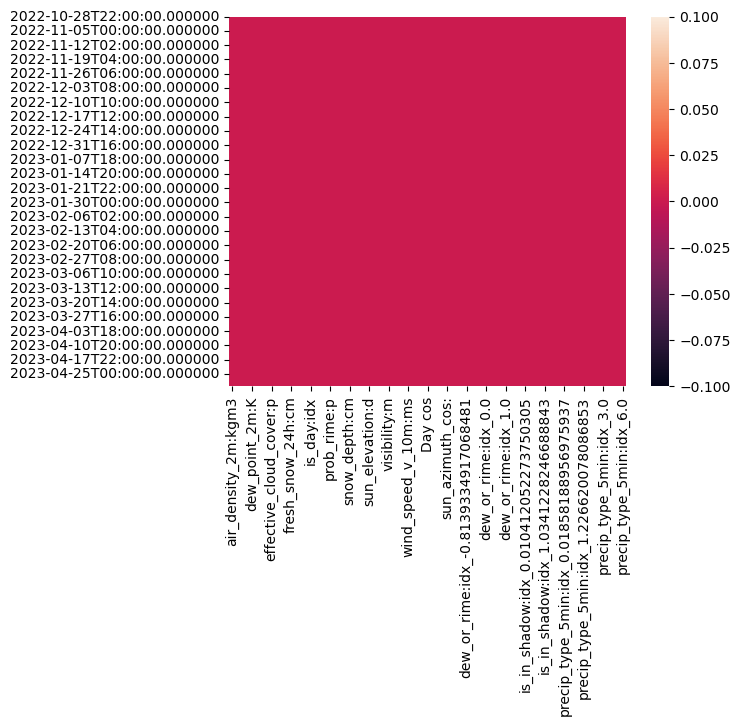

In [83]:
sns.heatmap(X_train_estimated_a_reg.isna())

### y Regressor

In [84]:
X_test_estimated_c.shape[1],X_train_observed_c.shape[1]

(65, 65)

In [85]:
normalizer = [y_a_reg.max().pv_measurement, y_b_reg.max().pv_measurement, y_c_reg.max().pv_measurement]
y_a_reg, y_b_reg, y_c_reg = y_a_reg/y_a_reg.max(), y_b_reg/y_b_reg.max(), y_c_reg/y_c_reg.max()

# 5. ImBalance Data (too much zero to forecast)
- Build 2 models, one binary classification, and another one for y>0 prediction

We create train_S_estimated_binary, train_S_observed_binary which indicates if y>0 of not.

In [86]:
# We modify Y to have a binary classification : 0 = no production of electricity
train_a_estimated_binary = pd.DataFrame({'pv_measurement' : train_a_estimated['pv_measurement']})
train_a_observed_binary = pd.DataFrame({'pv_measurement' : train_a_observed['pv_measurement']})

train_b_estimated_binary = pd.DataFrame({'pv_measurement' : train_b_estimated['pv_measurement']})
train_b_observed_binary = pd.DataFrame({'pv_measurement' : train_b_observed['pv_measurement']})

train_c_estimated_binary = pd.DataFrame({'pv_measurement' : train_c_estimated['pv_measurement']})
train_c_observed_binary = pd.DataFrame({'pv_measurement' : train_c_observed['pv_measurement']})

for time in train_a_estimated_binary.index:
    if train_a_estimated_binary.loc[time]['pv_measurement'] > 0 :
        train_a_estimated_binary.loc[time] = 1

for time in train_a_observed_binary.index:
    if train_a_observed_binary.loc[time]['pv_measurement'] > 0 :
        train_a_observed_binary.loc[time] = 1  
        
for time in train_b_estimated_binary.index:
    if train_b_estimated_binary.loc[time]['pv_measurement'] > 0 :
        train_b_estimated_binary.loc[time] = 1

for time in train_b_observed_binary.index:
    if train_b_observed_binary.loc[time]['pv_measurement'] > 0 :
        train_b_observed_binary.loc[time] = 1 
        
for time in train_c_estimated_binary.index:
    if train_c_estimated_binary.loc[time]['pv_measurement'] > 0 :
        train_c_estimated_binary.loc[time] = 1

for time in train_c_observed_binary.index:
    if train_c_observed_binary.loc[time]['pv_measurement'] > 0 :
        train_c_observed_binary.loc[time] = 1 

<Axes: >

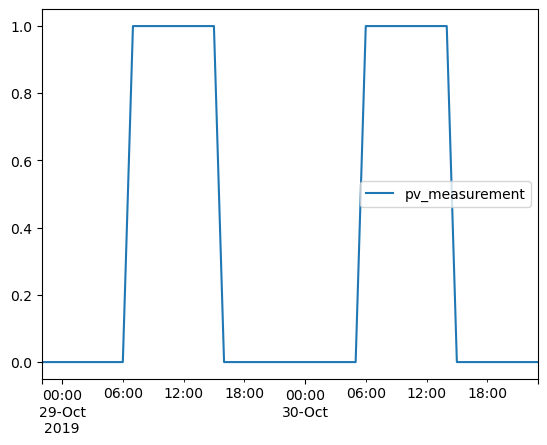

In [87]:
train_a_observed_binary.loc['2019-10-28 22:00:00':'2019-10-30 23:00:00'].plot()

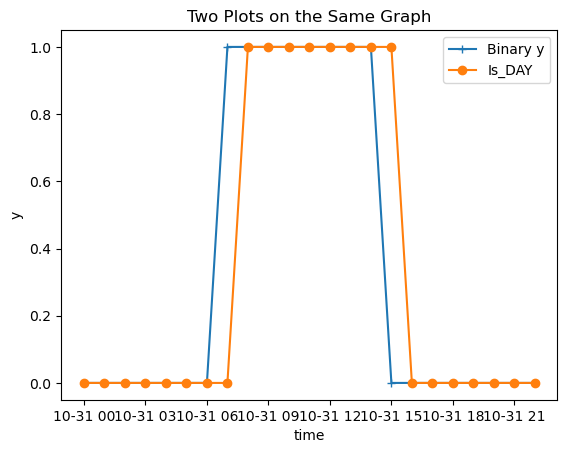

In [88]:
plt.plot(train_a_estimated_binary.loc['2022-10-31 00:00:00':'2022-10-31 22:00:0'], label='Binary y', marker ='+')
plt.plot( (X_train_estimated_a['is_day:idx'].loc['2022-10-31 00:00:00':'2022-10-31 22:00:0']) , label='Is_DAY',marker='o')

# Customize the plot (add labels, legend, title, etc. as needed)
plt.xlabel('time')
plt.ylabel('y')
plt.title('Two Plots on the Same Graph')
plt.legend()
plt.show()

In [89]:
(X_train_estimated_a['is_day:idx']-train_a_estimated_binary['pv_measurement']).abs().mean()*100,(X_train_estimated_b['is_day:idx']-train_b_estimated_binary['pv_measurement']).abs().mean()*100,(X_train_estimated_c['is_day:idx']-train_c_estimated_binary['pv_measurement']).abs().mean()*100

(5.12061902594447, 4.332129963898916, 7.8839590443686)

In [90]:
(X_train_observed_a['is_day:idx']-train_a_observed_binary['pv_measurement']).abs().mean()*100,(X_train_observed_b['is_day:idx']-train_b_observed_binary['pv_measurement']).abs().mean()*100,(X_train_observed_c['is_day:idx']-train_c_observed_binary['pv_measurement']).abs().mean()*100

(4.9280345164661075, 12.375932644260388, 9.36865304005877)

## Location A

In [91]:
X_test_estimated_c.shape[1],X_train_observed_c_reg.shape[1]

(65, 65)

In [92]:
def pos(x):
    if  x < 0:
        return 0
    else:
        return x

### Classifier A

In [93]:
from xgboost import XGBClassifier

In [94]:
X_a_class = pd.concat([X_train_observed_a, X_train_estimated_a], axis=0)
y_a_class = pd.concat([train_a_observed_binary, train_a_estimated_binary], axis=0)

In [95]:
X_a_class.shape, y_a_class.shape

((34061, 61), (34061, 1))

In [96]:
model_classifier = XGBClassifier(n_estimators=2000, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model_classifier.fit(X_a_class, y_a_class)
y_a_predict = model_classifier.predict(X_test_estimated_a)

In [97]:
df_pred_a = pd.DataFrame({'prediction' : y_a_predict}, index=X_test_estimated_a.index)
df_pred_a = df_pred_a[::4]
predict_indexes_a = df_pred_a[df_pred_a.prediction>.5].index
null_indexes_a = df_pred_a[df_pred_a.prediction<.5].index

<Axes: xlabel='date_forecast'>

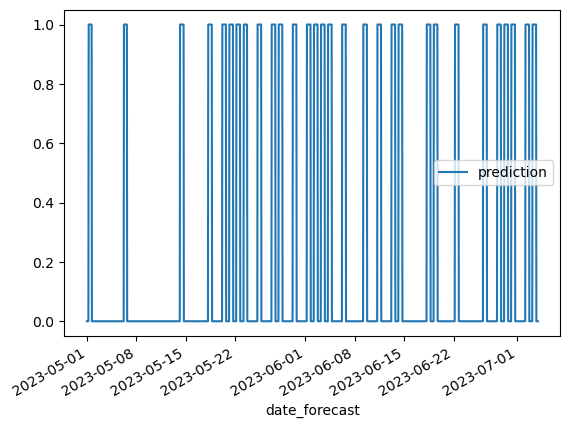

In [98]:
df_pred_a.plot()

### Regressor A

In [99]:
X_a = X_train_observed_a_reg
y_a = y_a_reg

In [100]:
X_a.shape, y_a.shape

((3746, 61), (3746, 1))

In [101]:
X_test_estimated_a_reg[::4].shape

(720, 61)

In [102]:
len(df_pred_a)

720

In [103]:
from xgboost import XGBRegressor
model_a = XGBRegressor(eval_metric='mae',
                        n_estimators=2000, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)

model_a.fit(X_a, y_a)
y_pred_a = model_a.predict(X_test_estimated_a_reg[::4])*normalizer[0]

for date in predict_indexes_a: 
        df_pred_a.loc[date] = pd.DataFrame({'prediction' : y_pred_a}, index=X_test_estimated_a_reg[::4].index).loc[date]
    
#We select the indexes with a positive or negative prediction 
#df_pred_a = pd.DataFrame({'prediction' : y_pred_a}, index=X_test_estimated_a.index)
df_pred_a['prediction'] = df_pred_a['prediction'].apply(lambda x: pos(x))

Text(0.5, 1.0, '2022')

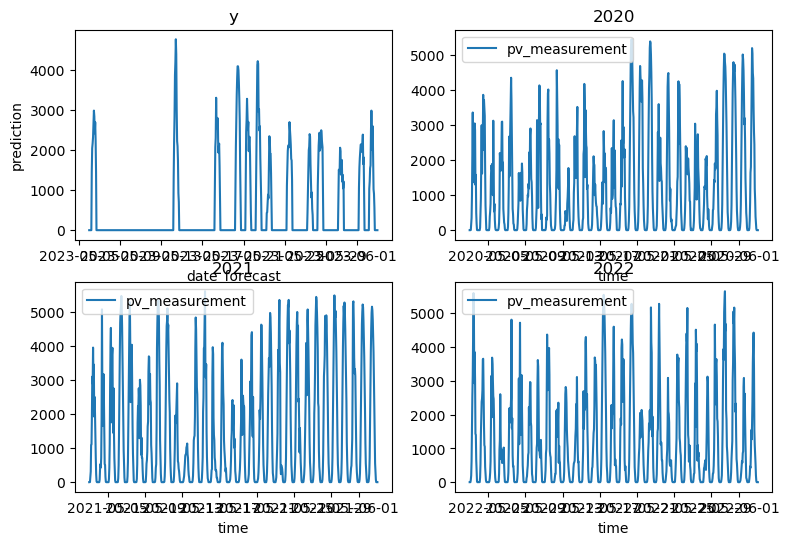

In [104]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))
axes = axes.flatten()

sns.lineplot(data=df_pred_a['prediction']['2023-05-03 00:00:00' : '2023-06-03 00:00:00'], ax=axes[0])
axes[0].set_title("y")

sns.lineplot(data=train_a['2020-05-03 00:00:00' : '2020-06-03 00:00:00'], ax=axes[1])
axes[1].set_title("2020")

sns.lineplot(data=train_a['2021-05-03 00:00:00' : '2021-06-03 00:00:00'], ax=axes[2])
axes[2].set_title("2021")

sns.lineplot(data=train_a['2022-05-03 00:00:00' : '2022-06-03 00:00:00'], ax=axes[3])
axes[3].set_title("2022")

<Axes: xlabel='date_forecast'>

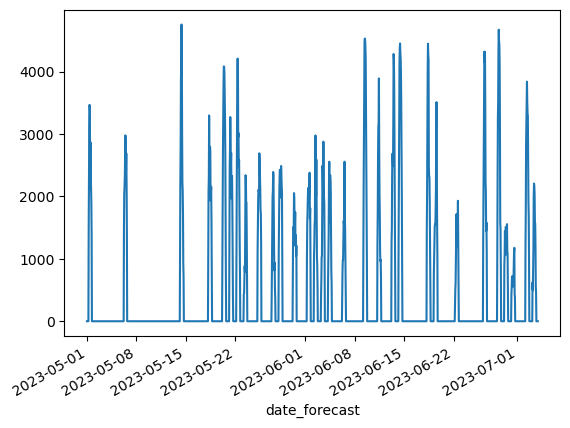

In [105]:
df_pred_a['prediction'].plot()

Text(0.5, 1.0, '2022')

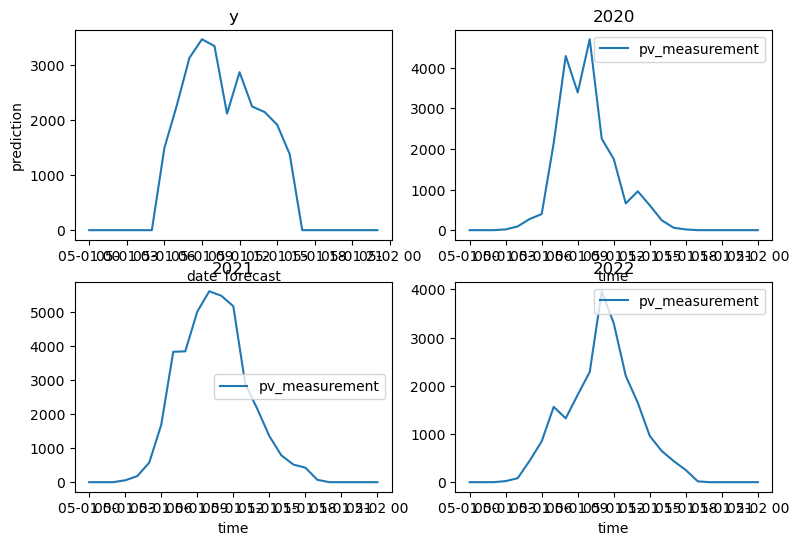

In [106]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))
axes = axes.flatten()

sns.lineplot(data=df_pred_a['prediction']['2023-05-01 00:00:00' : '2023-05-02 00:00:00'], ax=axes[0])
axes[0].set_title("y")

sns.lineplot(data=train_a['2020-05-01 00:00:00' : '2020-05-02 00:00:00'], ax=axes[1])
axes[1].set_title("2020")

sns.lineplot(data=train_a['2021-05-01 00:00:00' : '2021-05-02 00:00:00'], ax=axes[2])
axes[2].set_title("2021")

sns.lineplot(data=train_a['2022-05-01 00:00:00' : '2022-05-02 00:00:00'], ax=axes[3])
axes[3].set_title("2022")

In [107]:
# Transform the dataFrame of the prediction, to obtain the right file to submit
df_pred_a['location'] = ['A' for i in df_pred_a.index]
df_pred_a.reset_index(inplace = True)
df_pred_a.reset_index(inplace = True)
df_pred_a.columns = ['id', 'time', 'prediction', 'location']
df_pred_a

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.0,A
1,1,2023-05-01 01:00:00,0.0,A
2,2,2023-05-01 02:00:00,0.0,A
3,3,2023-05-01 03:00:00,0.0,A
4,4,2023-05-01 04:00:00,0.0,A
...,...,...,...,...
715,715,2023-07-03 19:00:00,0.0,A
716,716,2023-07-03 20:00:00,0.0,A
717,717,2023-07-03 21:00:00,0.0,A
718,718,2023-07-03 22:00:00,0.0,A


## Location C

### Classifier C

In [108]:
X_c_class = pd.concat([X_train_observed_c, X_train_estimated_c], axis=0)
y_c_class = pd.concat([train_c_observed_binary, train_c_estimated_binary], axis=0)

In [109]:
model_classifier_c = XGBClassifier(n_estimators=2000, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model_classifier_c.fit(X_c_class, y_c_class)
y_c_predict = model_classifier_c.predict(X_test_estimated_c)

In [110]:
df_pred_c = pd.DataFrame({'prediction' : y_c_predict}, index=X_test_estimated_c.index)
df_pred_c = df_pred_c[::4]
predict_indexes_c = df_pred_c[df_pred_c.prediction>.5].index

<Axes: xlabel='date_forecast'>

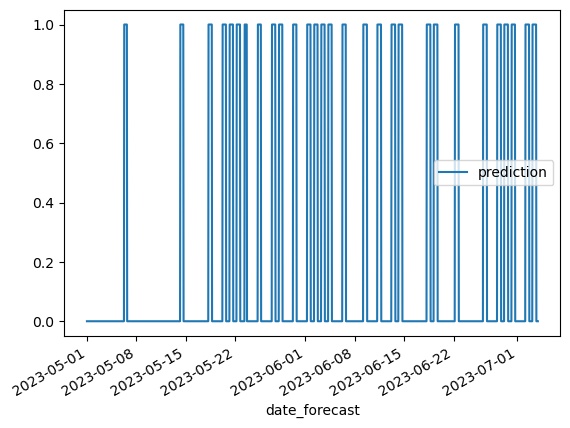

In [111]:
df_pred_c.plot()

### Regressor C

In [112]:
X_c = X_train_observed_c_reg
y_c = y_c_reg

In [113]:
X_c.shape

(2307, 65)

In [114]:
X_test_estimated_c_reg[::4].shape

(720, 65)

In [115]:
X_c.columns

Index(['air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_rad:W',
       'dew_point_2m:K', 'diffuse_rad:W', 'direct_rad:W',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'is_day:idx', 'msl_pressure:hPa', 'precip_5min:mm', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'snow_depth:cm',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_elevation:d',
       'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'Day sin', 'Day cos', 'Year sin', 'Year cos',
       'sun_azimuth_cos:', 'sun_azimuth_sin:',
       'dew_or_rime:idx_-1.0172467231750488', 'dew_or_rime:idx_-1.0',
       'dew_or_rime:idx_-0.22872447967529297',
       'dew_or_rime:idx_-0.015633821487426758', 'dew_or_rime:idx_0.0',
       'dew_or_rime:idx_0.011989163234829903',
   

In [116]:
X_test_estimated_c_reg.columns

Index(['air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_rad:W',
       'dew_point_2m:K', 'diffuse_rad:W', 'direct_rad:W',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'is_day:idx', 'msl_pressure:hPa', 'precip_5min:mm', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'snow_depth:cm',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_elevation:d',
       'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'Day sin', 'Day cos', 'Year sin', 'Year cos',
       'sun_azimuth_cos:', 'sun_azimuth_sin:',
       'dew_or_rime:idx_-1.0172467231750488', 'dew_or_rime:idx_-1.0',
       'dew_or_rime:idx_-0.22872447967529297',
       'dew_or_rime:idx_-0.015633821487426758', 'dew_or_rime:idx_0.0',
       'dew_or_rime:idx_0.011989163234829903',
   

In [117]:
model_c = XGBRegressor(eval_metric='mae',
                        n_estimators=2000, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)

model_c.fit(X_c, y_c)
y_pred_c = model_c.predict(X_test_estimated_c_reg[::4])*normalizer[2]

for date in predict_indexes_c: 
        df_pred_c.loc[date] = pd.DataFrame({'prediction' : y_pred_c}, index=X_test_estimated_c_reg[::4].index).loc[date]
    
df_pred_c['prediction'] = df_pred_c['prediction'].apply(lambda x: pos(x))

Text(0.5, 1.0, '2022')

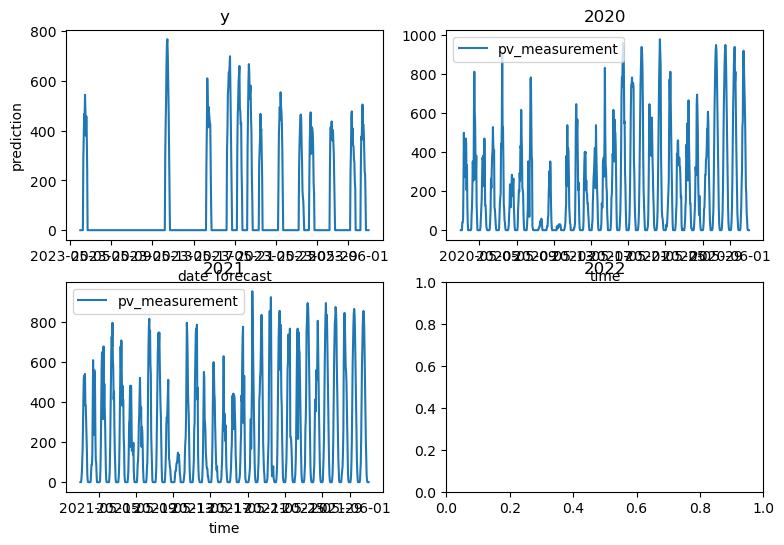

In [118]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))
axes = axes.flatten()

sns.lineplot(data=df_pred_c['prediction']['2023-05-03 00:00:00' : '2023-06-03 00:00:00'], ax=axes[0])
axes[0].set_title("y")

sns.lineplot(data=train_c['2020-05-03 00:00:00' : '2020-06-03 00:00:00'], ax=axes[1])
axes[1].set_title("2020")

sns.lineplot(data=train_c['2021-05-03 00:00:00' : '2021-06-03 00:00:00'], ax=axes[2])
axes[2].set_title("2021")

sns.lineplot(data=train_c['2022-05-03 00:00:00' : '2022-06-03 00:00:00'], ax=axes[3])
axes[3].set_title("2022")

<Axes: xlabel='date_forecast'>

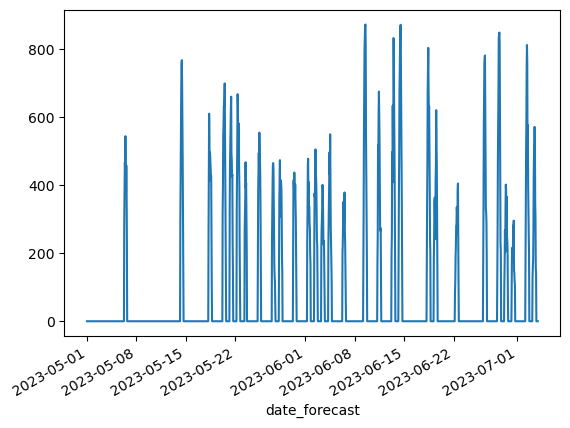

In [119]:
df_pred_c['prediction'].plot()

Text(0.5, 1.0, '2022')

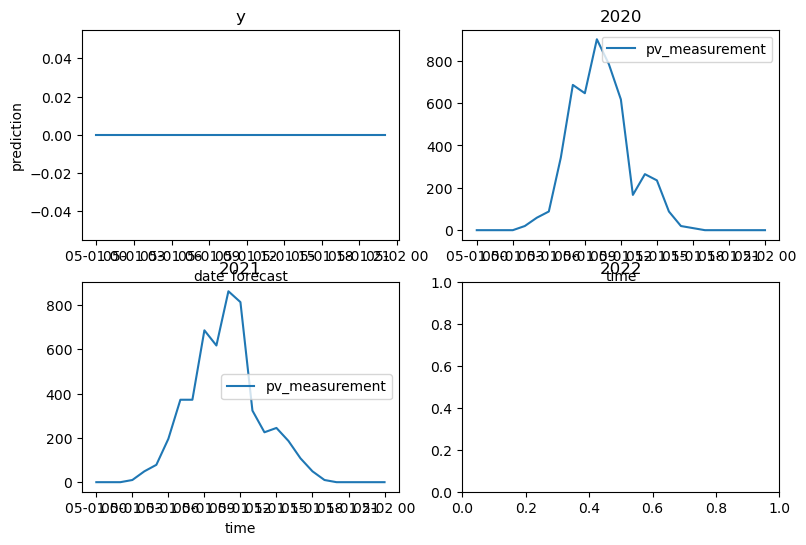

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))
axes = axes.flatten()

sns.lineplot(data=df_pred_c['prediction']['2023-05-01 00:00:00' : '2023-05-02 00:00:00'], ax=axes[0])
axes[0].set_title("y")

sns.lineplot(data=train_c['2020-05-01 00:00:00' : '2020-05-02 00:00:00'], ax=axes[1])
axes[1].set_title("2020")

sns.lineplot(data=train_c['2021-05-01 00:00:00' : '2021-05-02 00:00:00'], ax=axes[2])
axes[2].set_title("2021")

sns.lineplot(data=train_c['2022-05-01 00:00:00' : '2022-05-02 00:00:00'], ax=axes[3])
axes[3].set_title("2022")

In [121]:
# Transform the dataFrame of the prediction, to obtain the right file to submit
df_pred_c['location'] = ['C' for i in df_pred_c.index]
df_pred_c.reset_index(inplace = True)
df_pred_c.reset_index(inplace = True)
df_pred_c.columns = ['id', 'time', 'prediction', 'location']
df_pred_c

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.0,C
1,1,2023-05-01 01:00:00,0.0,C
2,2,2023-05-01 02:00:00,0.0,C
3,3,2023-05-01 03:00:00,0.0,C
4,4,2023-05-01 04:00:00,0.0,C
...,...,...,...,...
715,715,2023-07-03 19:00:00,0.0,C
716,716,2023-07-03 20:00:00,0.0,C
717,717,2023-07-03 21:00:00,0.0,C
718,718,2023-07-03 22:00:00,0.0,C


## Location B

### Classifier B

In [122]:
X_b_class = pd.concat([X_train_observed_b, X_train_estimated_b], axis=0)
y_b_class = pd.concat([train_b_observed_binary, train_b_estimated_binary], axis=0)

In [123]:
model_classifier = XGBClassifier(n_estimators=2000, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model_classifier.fit(X_b_class, y_b_class)
y_b_predict = model_classifier.predict(X_test_estimated_b)

In [124]:
df_pred_b = pd.DataFrame({'prediction' : y_a_predict}, index=X_test_estimated_a.index)
df_pred_b = df_pred_b[::4]
predict_indexes_b = df_pred_b[df_pred_b.prediction>.5].index

<Axes: xlabel='date_forecast'>

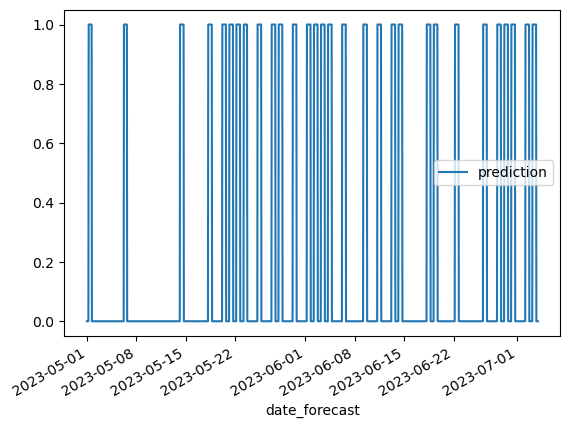

In [125]:
df_pred_b.plot()

### RegressorB

In [126]:
X_b = X_train_observed_b_reg
y_b = y_b_reg

In [127]:
X_test_estimated_b_reg.shape

(2880, 63)

In [128]:
model_b = XGBRegressor(eval_metric='mae',
                        n_estimators=2000, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)

model_b.fit(X_b, y_b)
y_pred_b = model_b.predict(X_test_estimated_b_reg[::4])*normalizer[1]

for date in predict_indexes_b: 
        df_pred_b.loc[date] = pd.DataFrame({'prediction' : y_pred_b}, index=X_test_estimated_b_reg[::4].index).loc[date]
    
df_pred_b['prediction'] = df_pred_b['prediction'].apply(lambda x: pos(x))

Text(0.5, 1.0, '2022')

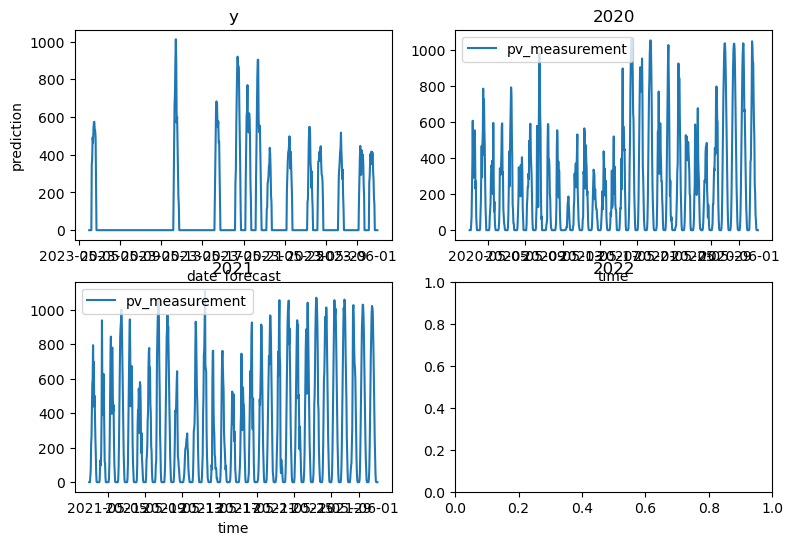

In [129]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))
axes = axes.flatten()

sns.lineplot(data=df_pred_b['prediction']['2023-05-03 00:00:00' : '2023-06-03 00:00:00'], ax=axes[0])
axes[0].set_title("y")

sns.lineplot(data=train_b['2020-05-03 00:00:00' : '2020-06-03 00:00:00'], ax=axes[1])
axes[1].set_title("2020")

sns.lineplot(data=train_b['2021-05-03 00:00:00' : '2021-06-03 00:00:00'], ax=axes[2])
axes[2].set_title("2021")

sns.lineplot(data=train_b['2022-05-03 00:00:00' : '2022-06-03 00:00:00'], ax=axes[3])
axes[3].set_title("2022")

<Axes: xlabel='date_forecast'>

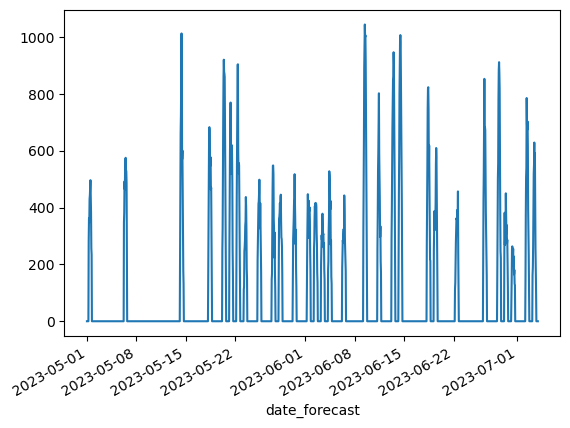

In [130]:
df_pred_b['prediction'].plot()

Text(0.5, 1.0, '2022')

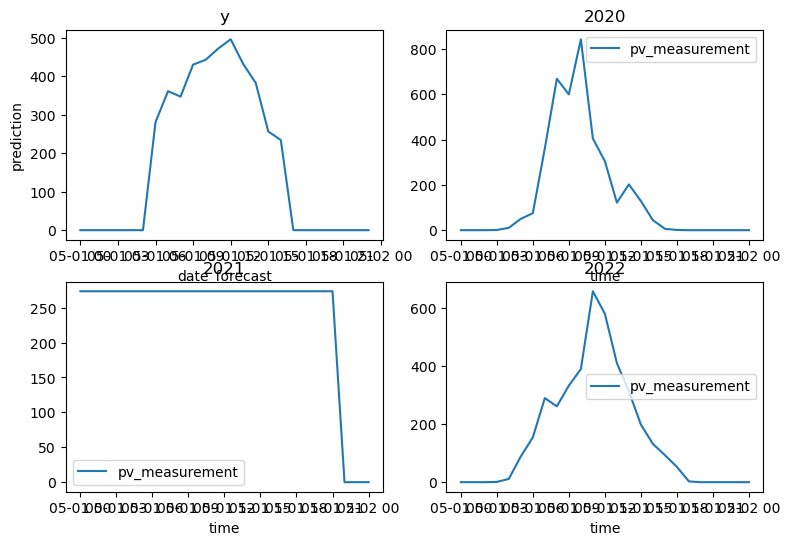

In [131]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))
axes = axes.flatten()

sns.lineplot(data=df_pred_b['prediction']['2023-05-01 00:00:00' : '2023-05-02 00:00:00'], ax=axes[0])
axes[0].set_title("y")

sns.lineplot(data=train_b['2020-05-01 00:00:00' : '2020-05-02 00:00:00'], ax=axes[1])
axes[1].set_title("2020")

sns.lineplot(data=train_b['2021-05-01 00:00:00' : '2021-05-02 00:00:00'], ax=axes[2])
axes[2].set_title("2021")

sns.lineplot(data=train_b['2022-05-01 00:00:00' : '2022-05-02 00:00:00'], ax=axes[3])
axes[3].set_title("2022")

In [132]:
# Transform the dataFrame of the prediction, to obtain the right file to submit
df_pred_b['location'] = ['B' for i in df_pred_b.index]
df_pred_b.reset_index(inplace = True)
df_pred_b.reset_index(inplace = True)
df_pred_b.columns = ['id', 'time', 'prediction', 'location']
df_pred_b

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.0,B
1,1,2023-05-01 01:00:00,0.0,B
2,2,2023-05-01 02:00:00,0.0,B
3,3,2023-05-01 03:00:00,0.0,B
4,4,2023-05-01 04:00:00,0.0,B
...,...,...,...,...
715,715,2023-07-03 19:00:00,0.0,B
716,716,2023-07-03 20:00:00,0.0,B
717,717,2023-07-03 21:00:00,0.0,B
718,718,2023-07-03 22:00:00,0.0,B


# Gather all the predictions

In [133]:
df_pred_a.head()

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.0,A
1,1,2023-05-01 01:00:00,0.0,A
2,2,2023-05-01 02:00:00,0.0,A
3,3,2023-05-01 03:00:00,0.0,A
4,4,2023-05-01 04:00:00,0.0,A


In [134]:
df_pred_b.head()

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.0,B
1,1,2023-05-01 01:00:00,0.0,B
2,2,2023-05-01 02:00:00,0.0,B
3,3,2023-05-01 03:00:00,0.0,B
4,4,2023-05-01 04:00:00,0.0,B


In [135]:
df_pred_c.head()

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.0,C
1,1,2023-05-01 01:00:00,0.0,C
2,2,2023-05-01 02:00:00,0.0,C
3,3,2023-05-01 03:00:00,0.0,C
4,4,2023-05-01 04:00:00,0.0,C


In [137]:
df_pred_total = pd.concat([df_pred_a, df_pred_b, df_pred_c], axis = 0)
df_pred_final = pd.DataFrame({'id' : [i for i in range(2160)], 'prediction' : df_pred_total['prediction'].to_numpy()})
df_pred_total
#df_pred_final[0:100]

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.0,A
1,1,2023-05-01 01:00:00,0.0,A
2,2,2023-05-01 02:00:00,0.0,A
3,3,2023-05-01 03:00:00,0.0,A
4,4,2023-05-01 04:00:00,0.0,A
...,...,...,...,...
715,715,2023-07-03 19:00:00,0.0,C
716,716,2023-07-03 20:00:00,0.0,C
717,717,2023-07-03 21:00:00,0.0,C
718,718,2023-07-03 22:00:00,0.0,C


In [138]:
df_pred_total

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.0,A
1,1,2023-05-01 01:00:00,0.0,A
2,2,2023-05-01 02:00:00,0.0,A
3,3,2023-05-01 03:00:00,0.0,A
4,4,2023-05-01 04:00:00,0.0,A
...,...,...,...,...
715,715,2023-07-03 19:00:00,0.0,C
716,716,2023-07-03 20:00:00,0.0,C
717,717,2023-07-03 21:00:00,0.0,C
718,718,2023-07-03 22:00:00,0.0,C


In [139]:
cd ../submission

/Users/marijansoric/Documents/GitHub/Solar-Energy-Production-Forecasting/submission


In [140]:
df_pred_final.to_csv('submission_19.csv', index=False)